In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id

from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5
from allen_v1dd.stimulus_analysis.fit_utils import r2_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")
at.set_included_mice(409828)
at.set_included_columns([2, 3, 4, 5])

# Percent responsive trials

In [4]:
df = []
DG_TYPES = ["windowed", "full"]

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    for dg_type in DG_TYPES:
        dg = group[f"drifting_gratings_{dg_type}"]
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        
        for roi in np.where(is_responsive)[0]:
            df.append(dict(
                mouse = mouse,
                column = column,
                volume = volume,
                plane = plane,
                roi = roi,
                depth = depth,
                dg_type = dg_type,
                frac_responsive_trials = dg["frac_responsive_trials"][roi]
            ))

df = pd.DataFrame(df)
df["pct_responsive_trials"] = df["frac_responsive_trials"] * 100

df

mouse  column  volume  plane  roi  depth   dg_type  \
0      409828       2       1      0    0     50  windowed   
1      409828       2       1      0    1     50  windowed   
2      409828       2       1      0    4     50  windowed   
3      409828       2       1      0  149     50  windowed   
4      409828       2       1      0    0     50      full   
...       ...     ...     ...    ...  ...    ...       ...   
33439  409828       5       5      5   52    514      full   
33440  409828       5       5      5   55    514      full   
33441  409828       5       5      5   67    514      full   
33442  409828       5       5      5   73    514      full   
33443  409828       5       5      5   74    514      full   

       frac_responsive_trials  pct_responsive_trials  
0                    0.666667              66.666667  
1                    0.500000              50.000000  
2                    0.750000              75.000000  
3                    0.625000              62.500000  
4                    0.750000              75.000000  
...                       ...                    ...  
33439                0.375000              37.500000  
33440                0.250000              25.000000  
33441                0.285714              28.571429  
33442                0.571429              57.142857  
33443                0.375000              37.500000  

[33444 rows x 9 columns]

In [5]:
def plot_dg_metric_by_depth(df, metric, color="lightgray"):
    fig, axs = plt.subplots(figsize=(10, 10), ncols=2)

    for dg_type, ax in zip(DG_TYPES, axs):
        df_sub = df[df.dg_type == dg_type]

        sns.boxplot(df_sub, y="depth", x=metric, color=color, orient="horizontal", ax=ax)
        ax.set_title(dg_type.upper())
        ax.set_ylabel("Depth (µm)")
    
    return fig, axs

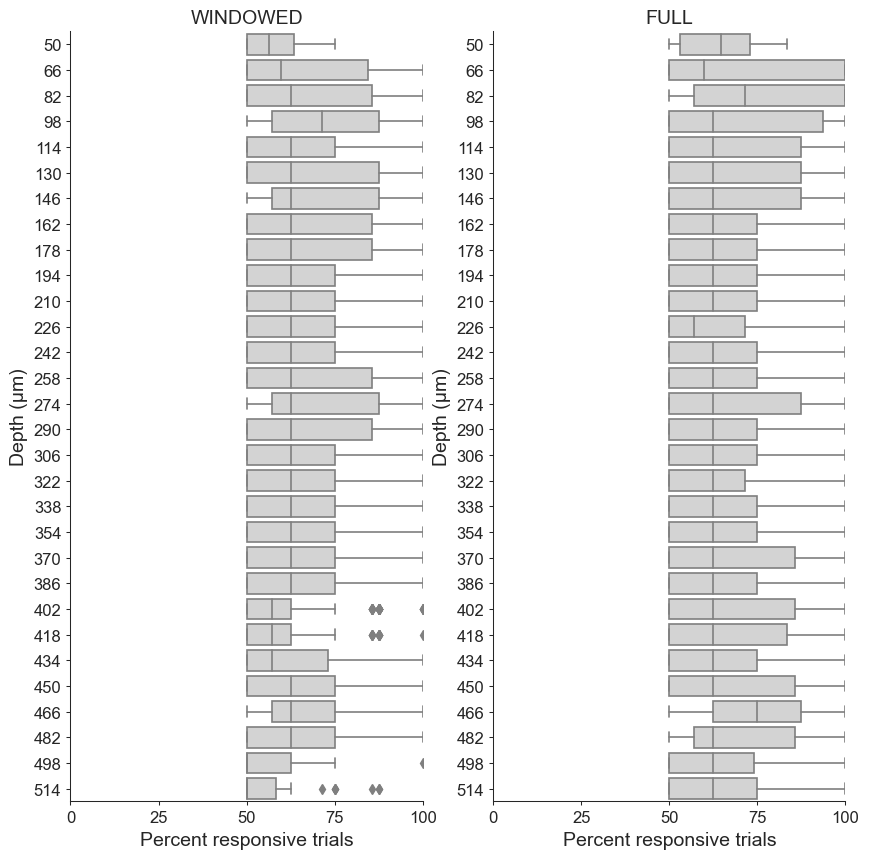

In [6]:
fig, axs = plot_dg_metric_by_depth(df[df.frac_responsive_trials >= 0.5], "pct_responsive_trials")

for ax in axs:
    ax.set_xlabel("Percent responsive trials")
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])

# Consistency of pref SF

In [135]:
df = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    for dg_type in DG_TYPES:
        dg = group[f"drifting_gratings_{dg_type}"]
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        pref_sf = dg["pref_cond_index"][:, 1]
        
        for roi in np.where(is_responsive)[0]:
            df.append(dict(
                roi = get_roi_id(group, roi),
                depth = depth,
                dg_type = dg_type,
                pref_sf = pref_sf[roi]
            ))

df = pd.DataFrame(df)
df

roi  depth   dg_type  pref_sf
0        M409828_21_0_0     50  windowed        0
1        M409828_21_0_1     50  windowed        0
2        M409828_21_0_4     50  windowed        0
3      M409828_21_0_149     50  windowed        0
4        M409828_21_0_0     50      full        0
...                 ...    ...       ...      ...
33439   M409828_55_5_52    514      full        0
33440   M409828_55_5_55    514      full        0
33441   M409828_55_5_67    514      full        0
33442   M409828_55_5_73    514      full        0
33443   M409828_55_5_74    514      full        1

[33444 rows x 4 columns]

roi
M409828_21_0_0      0
M409828_21_0_1      0
M409828_21_0_4      0
M409828_21_0_149    0
M409828_21_1_0      1
                   ..
M409828_55_5_49     0
M409828_55_5_52     1
M409828_55_5_55     1
M409828_55_5_67     1
M409828_55_5_73     0
Name: pref_sf, Length: 16363, dtype: int64

Text(0.5, 1.0, '$n = 20358$ total ROIs')

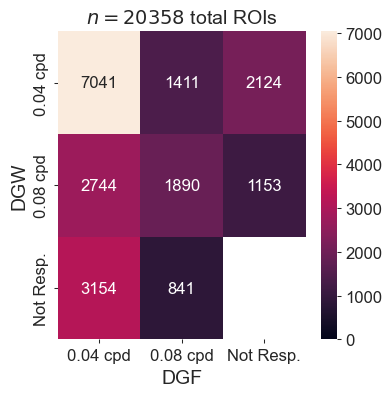

In [166]:
from tqdm.notebook import tqdm
counts = np.zeros((3, 3), dtype=float)
counts[2, 2] = np.nan
labels = ["0.04 cpd", "0.08 cpd", "Not Resp."]

wsf = df[df.dg_type == "windowed"].set_index("roi")["pref_sf"]
fsf = df[df.dg_type == "full"].set_index("roi")["pref_sf"]

for roi in df.roi.unique():
    if roi in wsf and roi in fsf: # DGW and DGF
        counts[wsf[roi], fsf[roi]] += 1
    elif roi not in fsf: # DGW and ~DGF
        counts[wsf[roi], 2] += 1
    elif roi not in wsf: # ~DGW and DGF
        counts[2, fsf[roi]] += 1

plt.figure(figsize=(4, 4))
sns.heatmap(counts, vmin=0, annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("DGF")
plt.ylabel("DGW")
plt.title(f"$n = {len(df.roi.unique())}$ total ROIs")

# Coefficient of variation of responses

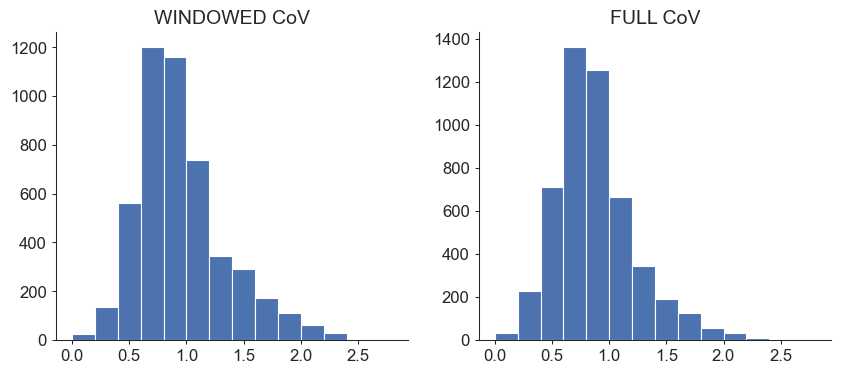

In [8]:
# Insert your ROI here
## roi_index = "M409828_13_1_26"
# roi_index = "M409828_13_4_19"
roi_index = "M409828_13_2_29" # SF
# roi_index = "M409828_13_2_158"
# roi_index = "M409828_13_2_83"

session_id, plane, roi = roi_index.rsplit("_", maxsplit=2)
plane = int(plane)
roi = int(roi)
mouse = roi_index.split("_", maxsplit=1)[0]

coef_of_var_dgw = []
coef_of_var_dgf = []

# for group in iter_plane_groups():
for group in iter_plane_groups(filter=dict(mouse=409828, column=1)):
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    dgs = group["drifting_gratings_windowed"], group["drifting_gratings_full"]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]
    
    for dg_type, dg, coef_of_var in zip(DG_TYPES, dgs, (coef_of_var_dgw, coef_of_var_dgf)):
        pref_cond_idx = dg["pref_cond_index"] # (roi, (dir, sf))
        trial_responses = dg["trial_responses"][()] # (roi, dir, sf, trial)
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        responsive_rois = np.where(is_responsive)[0]
        # coef_of_var = np.zeros_like(responsive_rois, dtype=float)

        for i, roi in enumerate(responsive_rois):
            dir_idx, sf_idx = pref_cond_idx[roi]
            resp = trial_responses[roi, dir_idx, sf_idx]
            resp = resp[~np.isnan(resp)]
            coef_of_var.append(resp.std() / resp.mean())

fig, axs = plt.subplots(figsize=(10, 4), ncols=2)

for ax, dg_type, coef_of_var in zip(axs, DG_TYPES, (coef_of_var_dgw, coef_of_var_dgf)):
    ax.hist(coef_of_var, bins=np.arange(0, 3, 0.2))
    ax.set_title(f"{dg_type.upper()} CoV")

# Running modulation

In [15]:
df_run_mod = []

for group in iter_plane_groups(filter=dict(mouse=[409828])):
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    if column == 1 and group.attrs["session_id"][-1] not in "abcdef":
        continue
    
    for roi in np.where(inclusion)[0]:
        df_run_mod.append(dict(
            mouse = mouse,
            column = column,
            volume = volume,
            plane = plane,
            roi = roi,
            depth = depth,
            run_mod = group["running_correlations"][roi],
        ))

df_run_mod = pd.DataFrame(df_run_mod)
df_run_mod

mouse  column volume  plane  roi  depth   run_mod
0      409828       1      a      0    0    600 -0.006471
1      409828       1      a      0    1    600 -0.028249
2      409828       1      a      0    2    600  0.015542
3      409828       1      a      0    3    600 -0.001677
4      409828       1      a      0    4    600 -0.003874
...       ...     ...    ...    ...  ...    ...       ...
23385  409828       5      5      5   55    514 -0.008496
23386  409828       5      5      5   67    514  0.005406
23387  409828       5      5      5   73    514 -0.000342
23388  409828       5      5      5   74    514  0.007968
23389  409828       5      5      5   75    514 -0.001332

[23390 rows x 7 columns]

<Axes: xlabel='count', ylabel='depth'>

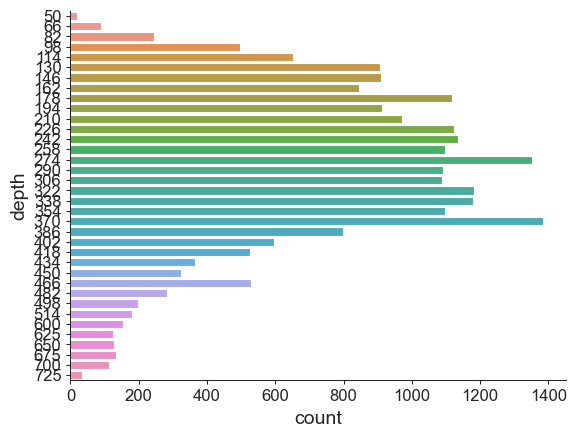

In [16]:
sns.countplot(df_run_mod, y="depth", orient="horizontal")

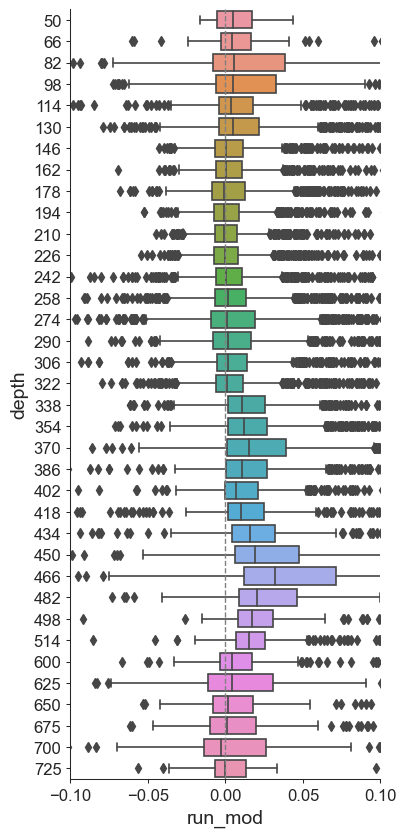

In [21]:
plt.figure(figsize=(4, 10))
sns.boxplot(df_run_mod, y="depth", x="run_mod", orient="horizontal")
plt.xlim(-0.1, 0.1)
plt.axvline(x=0, color="gray", linestyle="dashed", linewidth=1, zorder=10)

In [13]:
scipy.stats.pearsonr([1, 2, 3], [3, 3, 1]).confidence_interval()

ConfidenceInterval(low=-1.0, high=1.0)

# Cross validation procedure

In [107]:
import warnings
from sklearn.model_selection import StratifiedKFold

DG_TYPES = ["windowed", "full"]
DG_DIR_LIST = np.arange(0, 360, 30, dtype=int)

def get_running_stationary_trial_mask(dg):
    abs_trial_run_speed = np.abs(dg["trial_running_speeds"])
    run_mask = abs_trial_run_speed > 1
    stationary_mask = abs_trial_run_speed <= 1
    return run_mask, stationary_mask

class DGModelBase:
    def __init__(self, n_splits=5, shuffle_kfold=True):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle_kfold, random_state=42)
        self.state = {}


    def process_plane_group(self, group):
        inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
        mouse = group.attrs["mouse"]
        column = group.attrs["column"]
        volume = group.attrs["volume"]
        plane = group.attrs["plane"]
        depth = group.attrs["plane_depth_microns"]

        df_rows = []
        
        for dg_type in DG_TYPES:
            dg = group[f"drifting_gratings_{dg_type}"]
            self.update_state(dg)

            if not self.should_process_group(dg):
                continue
            
            is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
            responsive_rois = np.where(is_responsive)[0]
            trial_responses = dg["trial_responses"][()]
            pref_cond_idx = dg["pref_cond_index"][()]

            for roi in responsive_rois:
                roi_trial_responses = trial_responses[roi]
                pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]
                trial_index_matrix = self.get_trial_index_matrix(roi_trial_responses, pref_sf_idx)
                trial_labels = self.get_trial_labels(dg, trial_index_matrix)

                if not self.should_process_roi(dg, roi, trial_labels):
                    continue

                # Run cross-validation
                with warnings.catch_warnings():
                    warnings.simplefilter(action="ignore", category=UserWarning)
                    kfold_splits = list(self.skf.split(trial_index_matrix, trial_labels))

                fold_r_scores = []

                for fold, (train_idx, test_idx) in enumerate(kfold_splits):
                    train_trial_idx = trial_index_matrix[train_idx]
                    test_trial_idx = trial_index_matrix[test_idx]

                    y_true_fold = np.array([
                        roi_trial_responses[tuple(idx)]
                        for idx in test_trial_idx
                    ])

                    y_pred_fold = np.array(self.predict(dg, roi, roi_trial_responses, train_trial_idx, test_trial_idx))

                    # y_pred will be np.nan if there is no data with the corresponding label in the training set
                    # Ignore all nan predictions
                    mask = ~np.isnan(y_pred_fold)
                    y_true_fold = y_true_fold[mask]
                    y_pred_fold = y_pred_fold[mask]

                    # Compute and dsave R score
                    r_result = scipy.stats.pearsonr(y_true_fold, y_pred_fold)
                    r = r_result.statistic
                    fold_r_scores.append(r)

                # Compute metrics and save results
                r = np.mean(fold_r_scores)

                df_rows.append(dict(
                    mouse = mouse,
                    column = column,
                    volume = volume,
                    plane = plane,
                    roi = roi,
                    depth = depth,
                    dg_type = dg_type,
                    # r2 = r2,
                    r = r,
                    frac_responsive_trials = dg["frac_responsive_trials"][roi],
                    run_mod = group["running_correlations"][roi]
                ))
            
        return df_rows


    def update_state(self, dg):
        pass


    def get_trial_index_matrix(self, roi_trial_responses, pref_sf_idx):
        trial_index_matrix = []

        for dir_i in range(roi_trial_responses.shape[0]):
            for trial in range(roi_trial_responses.shape[2]):
                if not np.isnan(roi_trial_responses[dir_i, pref_sf_idx, trial]):
                    trial_index_matrix.append([dir_i, pref_sf_idx, trial])
        
        return np.array(trial_index_matrix)
    

    def get_trial_labels(self, dg, trial_index_matrix):
        """Returns labels for each trial, which define how the data is split in K-folds.
        Meant to be overridden in subclasses, but by default returns the DG direction so
        each fold has approximately the same number of trials of different directions.

        Args:
            dg (hdf5 group): DG group
            trial_index_matrix (np.ndarray): Trial index matrix from get_trial_index_matrix.

        Returns:
            arraylike: Labels for each trial, such that the ith value matches the ith trial in trial_index_matrix.
                       By default, the trial is labeled by the direction of the DG stimulus.
        """
        return trial_index_matrix[:, 0]


    def should_process_group(self, dg):
        """Whether a DG group should be processed. By default returns True.

        Args:
            dg (hdf5 group): DG group

        Returns:
            bool: Whether to process a DG group
        """
        return True
    

    def should_process_roi(self, dg, roi, trial_labels):
        return True

    def predict(self, dg, roi, roi_trial_responses, train_trial_indices, test_trial_indices):
        raise NotImplementedError("predict not implemented")


class DGModelMeanTuningNoRunning(DGModelBase):
    def predict(self, dg, roi, roi_trial_responses, train_trial_indices, test_trial_indices):
        # Compute mean repsonse for each direction
        tuning_curve = [[] for _ in range(roi_trial_responses.shape[0])]

        for idx in train_trial_indices:
            tuning_curve[idx[0]].append(roi_trial_responses[tuple(idx)])

        tuning_curve = [np.mean(r) if len(r) > 0 else np.nan for r in tuning_curve]

        # Compute predictions on test values
        y_pred = [
            tuning_curve[idx[0]]
            for idx in test_trial_indices
        ]

        return y_pred


class DGModelMeanTuningWithRunning(DGModelBase):
    def update_state(self, dg):
        running_mask, stationary_mask = get_running_stationary_trial_mask(dg)
        self.state["running_mask"] = running_mask
        self.state["stationary_mask"] = stationary_mask

    def should_process_roi(self, dg, roi, trial_labels):
        # Only fit the ROI repsonses if there is at least one running/stationary trial for each direction
        # trial_labels = set(trial_labels)
        # return len(trial_labels) == 24

        label_counts = np.zeros(24, dtype=int)
        for l in trial_labels: label_counts[l] += 1
        atmost1nodata = (label_counts[:12] == 0).sum() <= 1 and (label_counts[12:] == 0).sum() <= 1

        # If there are at least 3 in the pref direction
        pref_dir_idx = dg["pref_cond_index"][roi, 0]
        atleast3inprefdir = label_counts[pref_dir_idx] >= 3 and label_counts[pref_dir_idx + 12] >= 3

        # return atmost1nodata and atleast3inprefdir
        return atleast3inprefdir


    def get_trial_labels(self, dg, trial_index_matrix):
        """There are 24 different labels. 
        Labels 0, 1, ..., 11 are given to trials of each direction where the mouse is STATIONARY.
        Labels 12, 13, ..., 23 are given to trials of each direction where the mouse is RUNNING.
        """
        labels = []
        running_mask = self.state["running_mask"]

        for idx in trial_index_matrix:
            dir_idx = idx[0]
            is_running_trial = running_mask[tuple(idx)]
            labels.append(dir_idx + (len(DG_DIR_LIST) if is_running_trial else 0))

        return labels

    def predict(self, dg, roi, roi_trial_responses, train_trial_indices, test_trial_indices):
        # Compute mean repsonse for each direction at running and stationary
        running_mask = self.state["running_mask"]
        tuning_running = [[] for _ in range(roi_trial_responses.shape[0])]
        tuning_stationary = [[] for _ in range(roi_trial_responses.shape[0])]

        for idx in train_trial_indices:
            idx = tuple(idx)
            is_running_trial = running_mask[idx]
            response = roi_trial_responses[idx]
            (tuning_running if is_running_trial else tuning_stationary)[idx[0]].append(response)

        tuning_running = [np.mean(r) if len(r) > 0 else np.nan for r in tuning_running]
        tuning_stationary = [np.mean(r) if len(r) > 0 else np.nan for r in tuning_stationary]

        # Compute predictions on test values
        y_pred = [
            (tuning_running if running_mask[tuple(idx)] else tuning_stationary)[idx[0]]
            for idx in test_trial_indices
        ]

        return y_pred


In [24]:
model_1 = DGModelMeanTuningNoRunning()
df_model_1 = []

for group in iter_plane_groups(filter=dict(mouse=409828, column=[1])):
    df_model_1.extend(model_1.process_plane_group(group))

df_model_1 = pd.DataFrame(df_model_1)
df_model_1

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scip

mouse  column volume  plane  roi  depth   dg_type         r  \
0     409828       1      1      0   89     50  windowed  0.165937   
1     409828       1      1      0   89     50      full  0.208470   
2     409828       1      1      1    2     66  windowed  0.155872   
3     409828       1      1      1    4     66  windowed  0.145856   
4     409828       1      1      1  159     66  windowed  0.156471   
...      ...     ...    ...    ...  ...    ...       ...       ...   
9848  409828       1      f      0   38    725      full  0.421519   
9849  409828       1      f      0   69    725      full       NaN   
9850  409828       1      f      0   70    725      full  0.019895   
9851  409828       1      f      0   74    725      full  0.149530   
9852  409828       1      f      0   90    725      full  0.229845   

      frac_responsive_trials   run_mod  
0                   0.375000  0.011718  
1                   0.500000  0.011718  
2                   0.500000 -0.028937  
3                   0.428571  0.007350  
4                   0.500000  0.005391  
...                      ...       ...  
9848                0.625000  0.006173  
9849                0.250000  0.031299  
9850                0.625000 -0.036722  
9851                0.375000 -0.008312  
9852                0.400000  0.003390  

[9853 rows x 10 columns]

In [57]:
COLOR_RUN = "b"
COLOR_STATIONARY = "r"

def plot_dg_responses(mouse, column, volume, plane, roi, dg_type="windowed", plot_tuning_curve=True, consider_running=False, subtitle=None, ax=None, show_running_text=True):
    for group in iter_plane_groups(filter=dict(mouse=mouse, column=column, volume=volume, plane=plane)):
        dg = group[f"drifting_gratings_{dg_type}"]
        trial_responses = dg["trial_responses"][()]
        pref_sf_idx = dg["pref_cond_index"][roi, 1]

        # Plot responses
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

        if consider_running:
            run_mask, stationary_mask = get_running_stationary_trial_mask(dg)

            for di, angle in enumerate(DG_DIR_LIST):
                resp_run = trial_responses[roi, di, pref_sf_idx, run_mask[di, pref_sf_idx]]
                resp_stat = trial_responses[roi, di, pref_sf_idx, stationary_mask[di, pref_sf_idx]]
                ax.scatter([angle] * len(resp_run), resp_run, color=COLOR_RUN, s=30, alpha=0.75)
                ax.scatter([angle] * len(resp_stat), resp_stat, color=COLOR_STATIONARY, s=30, alpha=0.75)
            
            if plot_tuning_curve:
                tuning_run = np.nanmean(np.where(run_mask, trial_responses[roi], np.nan)[:, pref_sf_idx, :], axis=1) # trial average
                tuning_stat = np.nanmean(np.where(stationary_mask, trial_responses[roi], np.nan)[:, pref_sf_idx], axis=1)

                ax.plot(DG_DIR_LIST, tuning_run, color=COLOR_RUN, linewidth=2)
                ax.plot(DG_DIR_LIST, tuning_stat, color=COLOR_STATIONARY, linewidth=2)
        
            if show_running_text:
                ax.text(1, 0.99, "Run", color=COLOR_RUN, va="bottom", ha="left", transform=ax.transAxes)
                ax.text(1, 0.97, "Stationary", color=COLOR_STATIONARY, va="top", ha="left", transform=ax.transAxes)
        else:
            for di, angle in enumerate(DG_DIR_LIST):
                resp = trial_responses[roi, di, pref_sf_idx]
                resp = resp[~np.isnan(resp)]
                angle_list = [angle] * len(resp)
                ax.scatter(angle_list, resp, color="black", s=30, alpha=0.75)

            if plot_tuning_curve:
                tuning = np.nanmean(trial_responses[roi, :, pref_sf_idx, :], axis=1)
                ax.plot(DG_DIR_LIST, tuning, color="black", linewidth=2)

        # if plot_tuning_curve:
        #     if consider_running:
        #         for di, angle in enumerate(DG_DIR_LIST):
        #             resp_run = trial_responses[roi, di, pref_sf_idx, is_running[di, pref_sf_idx]]
        #             resp_stat = trial_responses[roi, di, pref_sf_idx, is_stationary[di, pref_sf_idx]]

        #             ax.scatter([angle] * len(resp_run), resp_run, color=COLOR_RUN, s=20, alpha=0.75)
        #             ax.scatter([angle] * len(resp_stat), resp_stat, color=COLOR_STATIONARY, s=20, alpha=0.75)

        #         ax.plot(dir_list, tuning_curve_run, color=COLOR_RUN, linewidth=2)
        #         ax.plot(dir_list, tuning_curve_stat, color=COLOR_STATIONARY, linewidth=2)

        #         ax.set_xticks(dir_list)
        #         ax.set_xlim(dir_list[0]-10, dir_list[-1]+10)
        #         ax.set_title(f"M{mouse}_{column}{volume}, Plane {plane}, ROI {roi} [{dg_type.upper()}]\n$R$ = {r:.4f},   $R^2$ = {r2:.4f}")
        #         ax.set_ylabel("Response (a.u.)")
        
        #     else:
        #         tuning_curve = np.nanmean(trial_responses[roi, :, pref_sf_idx, :], axis=1)

        # ax.plot(dir_list, tuning_curve, linewidth=2, color="black")

        title = f"M{mouse}_{column}{volume}, Plane {plane}, ROI {roi} [{dg_type.upper()}]"
        if subtitle is not None: title = f"{title}\n{subtitle}"
        ax.set_title(title)
        ax.set_xlabel("DG direction (°)")
        ax.set_ylabel("ROI response")
        ax.set_xlabel("")
        ax.set_xticks(DG_DIR_LIST, labels=[f"{d}°" for d in DG_DIR_LIST])
        ax.set_xlim(DG_DIR_LIST[0]-10, DG_DIR_LIST[-1]+10)

        return ax

    print("ERROR: Couldn't find trial responses for ROI")
    return None


<Axes: xlabel='r', ylabel='Count'>

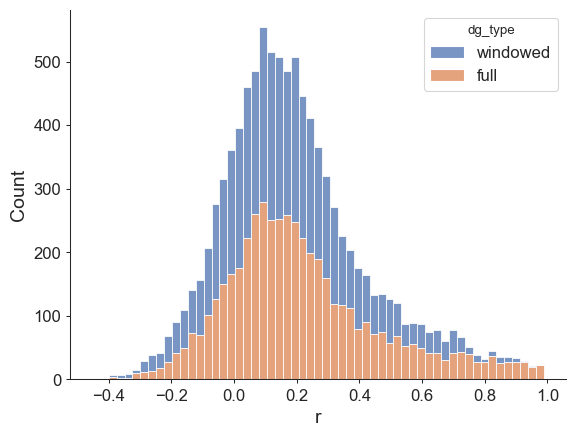

In [52]:
sns.histplot(data=df_model_1, x="r", hue="dg_type", multiple="stack")

Text(0.5, 1.0, 'Mean = 0.197')

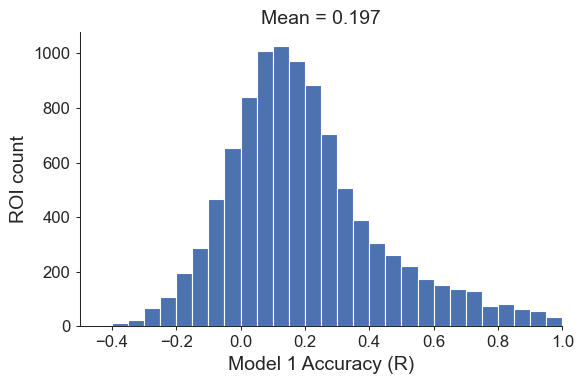

In [128]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.hist(df_model_1.r, bins=np.arange(-1, 1.05, 0.05))
ax.set_xlabel("Model 1 Accuracy (R)")
ax.set_ylabel("ROI count")
ax.set_xlim(-0.5, 1)
ax.set_title(f"Mean = {df_model_1.r.mean():.3f}")

In [72]:
def get_metric(df, metric, dg_type, mouse, column, volume, plane, roi):
    df = df[(df.mouse == mouse) & (df.column == column) & (df.volume == volume) & (df.plane == plane) & (df.roi == roi) & (df.dg_type == dg_type)]
    if len(df) == 0:
        return "N/A"
    else:
        return df[metric].iloc[0]

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:24: RuntimeWarning: Mean of empty slice
  tuning_run = np.nanmean(np.where(run_mask, trial_responses[roi], np.nan)[:, pref_sf_idx, :], axis=1) # trial average
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:25: RuntimeWarning: Mean of empty slice
  tuning_stat = np.nanmean(np.where(stationary_mask, trial_responses[roi], np.nan)[:, pref_sf_idx], axis=1)


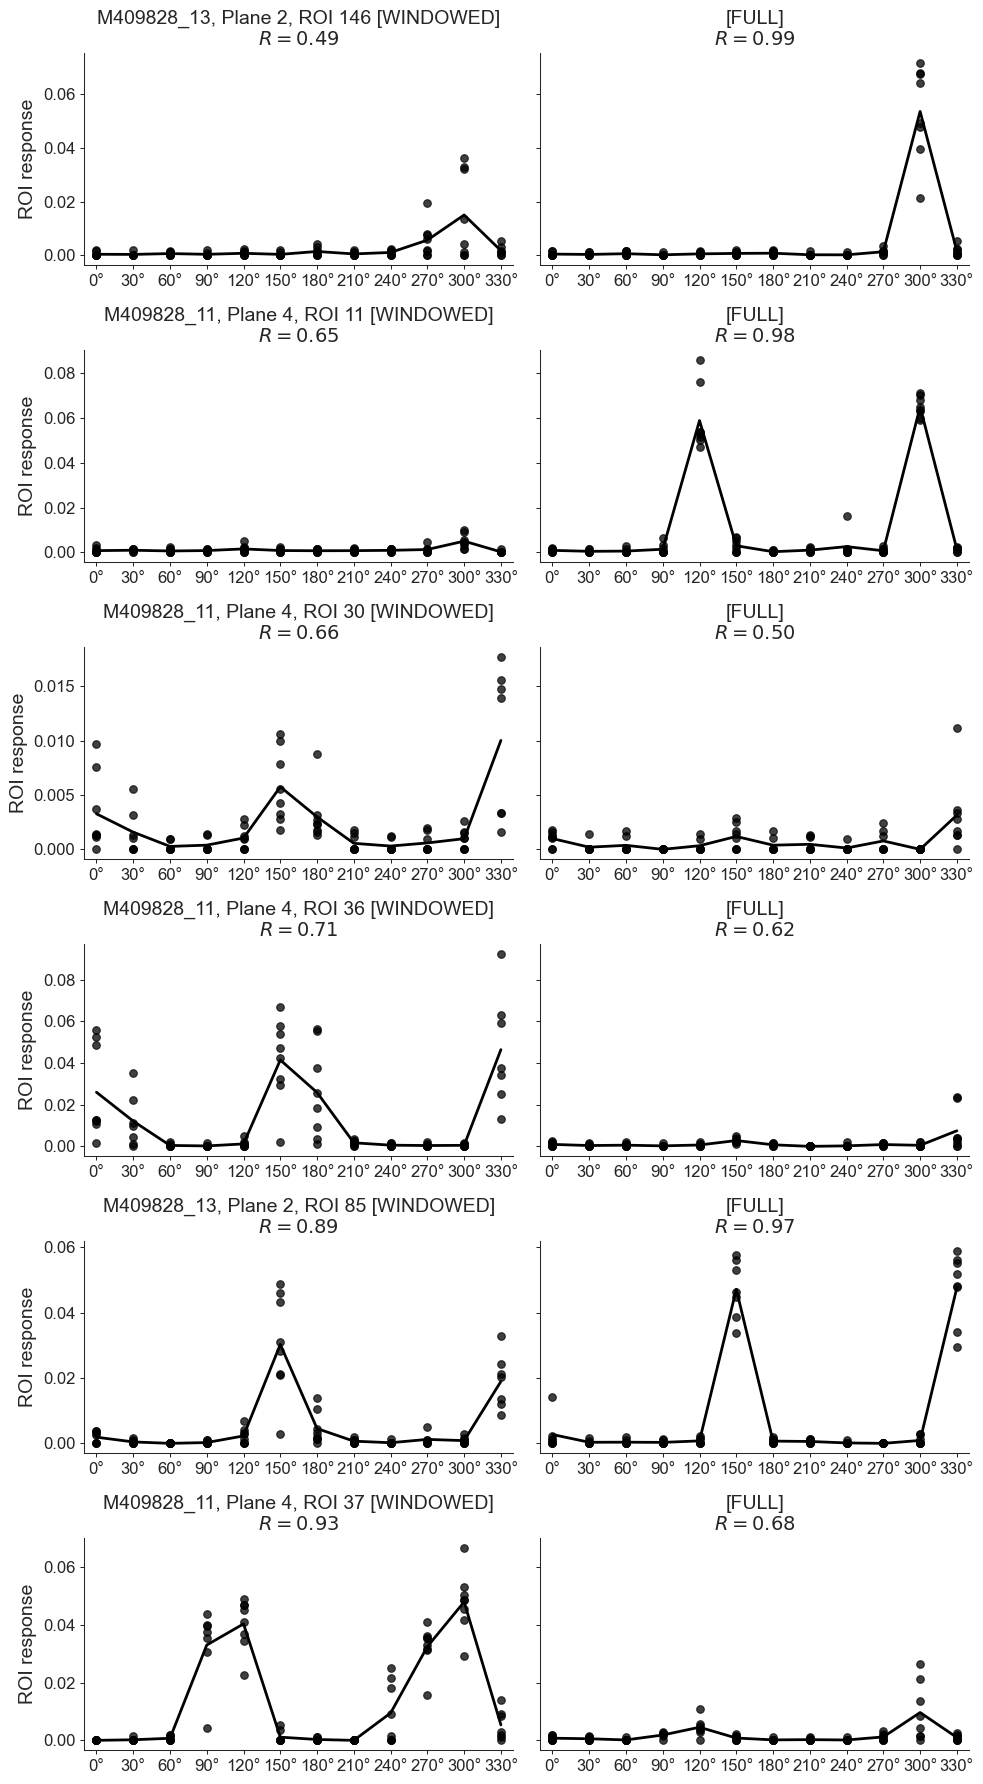

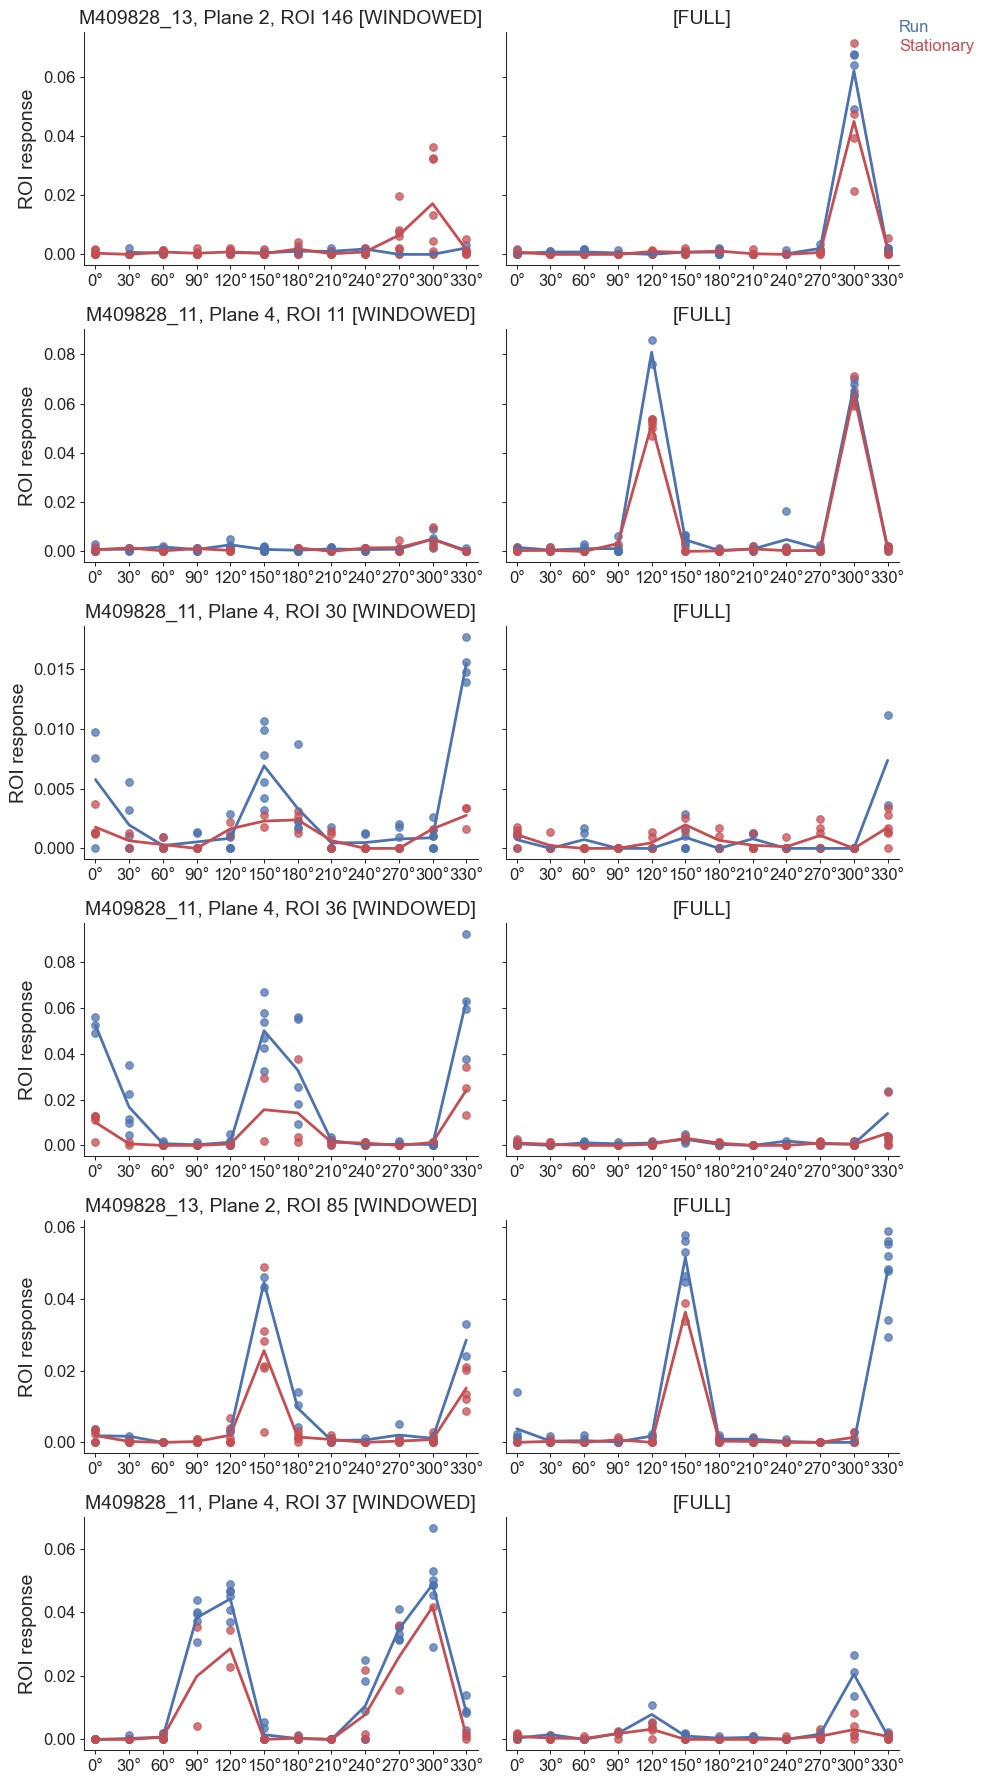

In [116]:
rois_to_plot = [
    (409828, 1, 3, 2, 146),
    (409828, 1, 1, 4, 11),
    (409828, 1, 1, 4, 30),
    (409828, 1, 1, 4, 36),
    (409828, 1, 3, 2, 85),
    # (409828, 1, 2, 2, 28),
    (409828, 1, 1, 4, 37)
]
fig, axs = plt.subplots(figsize=(10, 3*len(rois_to_plot)), tight_layout=True, nrows=len(rois_to_plot), ncols=2, sharey="row")

for row, roi_id in enumerate(rois_to_plot):
    plot_dg_responses(*roi_id, dg_type="windowed", consider_running=False, ax=axs[row, 0], subtitle=f"$R = {get_metric(df_model_1, 'r', 'windowed', *roi_id):.2f}$")
    plot_dg_responses(*roi_id, dg_type="full", consider_running=False, ax=axs[row, 1])
    axs[row, 1].set_ylabel("")
    axs[row, 1].set_title(f"[FULL]\n$R = {get_metric(df_model_1, 'r', 'full', *roi_id):.2f}$")

fig, axs = plt.subplots(figsize=(10, 3*len(rois_to_plot)), tight_layout=True, nrows=len(rois_to_plot), ncols=2, sharey="row")

for row, roi_id in enumerate(rois_to_plot):
    plot_dg_responses(*roi_id, dg_type="windowed", consider_running=True, ax=axs[row, 0], show_running_text=False)
    plot_dg_responses(*roi_id, dg_type="full", consider_running=True, ax=axs[row, 1], show_running_text=(row==0))
    axs[row, 1].set_ylabel("")
    axs[row, 1].set_title("[FULL]")

# df_sorted = df_model_1.sort_values("r", ascending=False)

# for row in df_sorted[df_sorted.dg_type == "windowed"].head(10).itertuples():
#     i = row[0]
#     plot_dg_responses(*row[1:6], dg_type=df_model_1.at[i, "dg_type"], consider_running=False, subtitle=f"$R = {df_model_1.at[i, 'r']:.2f}$")
#    plot_dg_responses(*row[1:6], dg_type="full", consider_running=False, subtitle=f"$R = {df_model_1.at[i, 'r']:.2f}$")
#    # break

# df_sorted

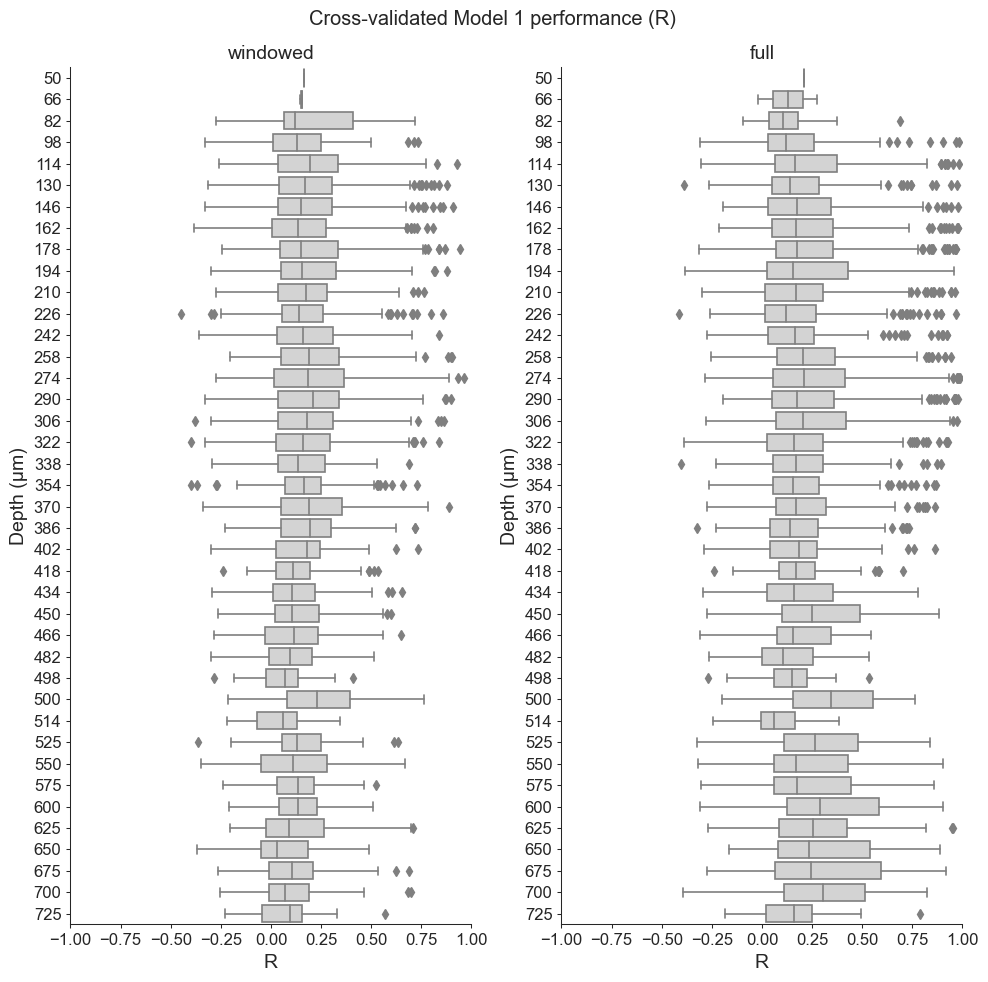

In [130]:
fig, axs = plot_dg_metric_by_depth(df_model_1, "r")
fig.suptitle("Cross-validated Model 1 performance (R)")
for ax, dg_type in zip(axs, DG_TYPES):
    ax.set_title(dg_type)
    ax.set_xlabel("R")
    ax.set_xlim(-1, 1)
fig.tight_layout()

In [108]:
model_2 = DGModelMeanTuningWithRunning()
df_model_2 = []

for group in iter_plane_groups(filter=dict(mouse=409828, column=[1])):
    df_model_2.extend(model_2.process_plane_group(group))

df_model_2 = pd.DataFrame(df_model_2)
df_model_2

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


mouse  column volume  plane  roi  depth   dg_type         r  \
0     409828       1      1      0   89     50  windowed  0.153334   
1     409828       1      1      1    4     66  windowed -0.194643   
2     409828       1      1      2   15     82  windowed  0.551443   
3     409828       1      1      2   17     82  windowed  0.768863   
4     409828       1      1      2  766     82  windowed  0.289715   
...      ...     ...    ...    ...  ...    ...       ...       ...   
2431  409828       1      f      0    0    725      full -0.026704   
2432  409828       1      f      0    2    725      full  0.066941   
2433  409828       1      f      0    9    725      full  0.142676   
2434  409828       1      f      0   21    725      full  0.121535   
2435  409828       1      f      0   30    725      full -0.090211   

      frac_responsive_trials   run_mod  
0                   0.375000  0.011718  
1                   0.428571  0.007350  
2                   0.571429  0.040576  
3                   1.000000  0.125417  
4                   0.250000  0.009319  
...                      ...       ...  
2431                0.285714 -0.012831  
2432                0.250000 -0.007846  
2433                0.500000 -0.005268  
2434                0.428571  0.096865  
2435                0.250000 -0.000789  

[2436 rows x 10 columns]

In [84]:
df_model_1[["mouse", "column", "volume", "plane", "roi"]].value_counts().value_counts()

2    3563
1    2727
dtype: int64

In [109]:
df_model_2[["mouse", "column", "volume", "plane", "roi"]].value_counts().value_counts()

1    1826
2     305
dtype: int64

In [110]:
def format_r2(*args):
    met = get_metric(*args)
    return met if met == "N/A" else f"{met:.2f}"

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:24: RuntimeWarning: Mean of empty slice
  tuning_run = np.nanmean(np.where(run_mask, trial_responses[roi], np.nan)[:, pref_sf_idx, :], axis=1) # trial average
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:25: RuntimeWarning: Mean of empty slice
  tuning_stat = np.nanmean(np.where(stationary_mask, trial_responses[roi], np.nan)[:, pref_sf_idx], axis=1)


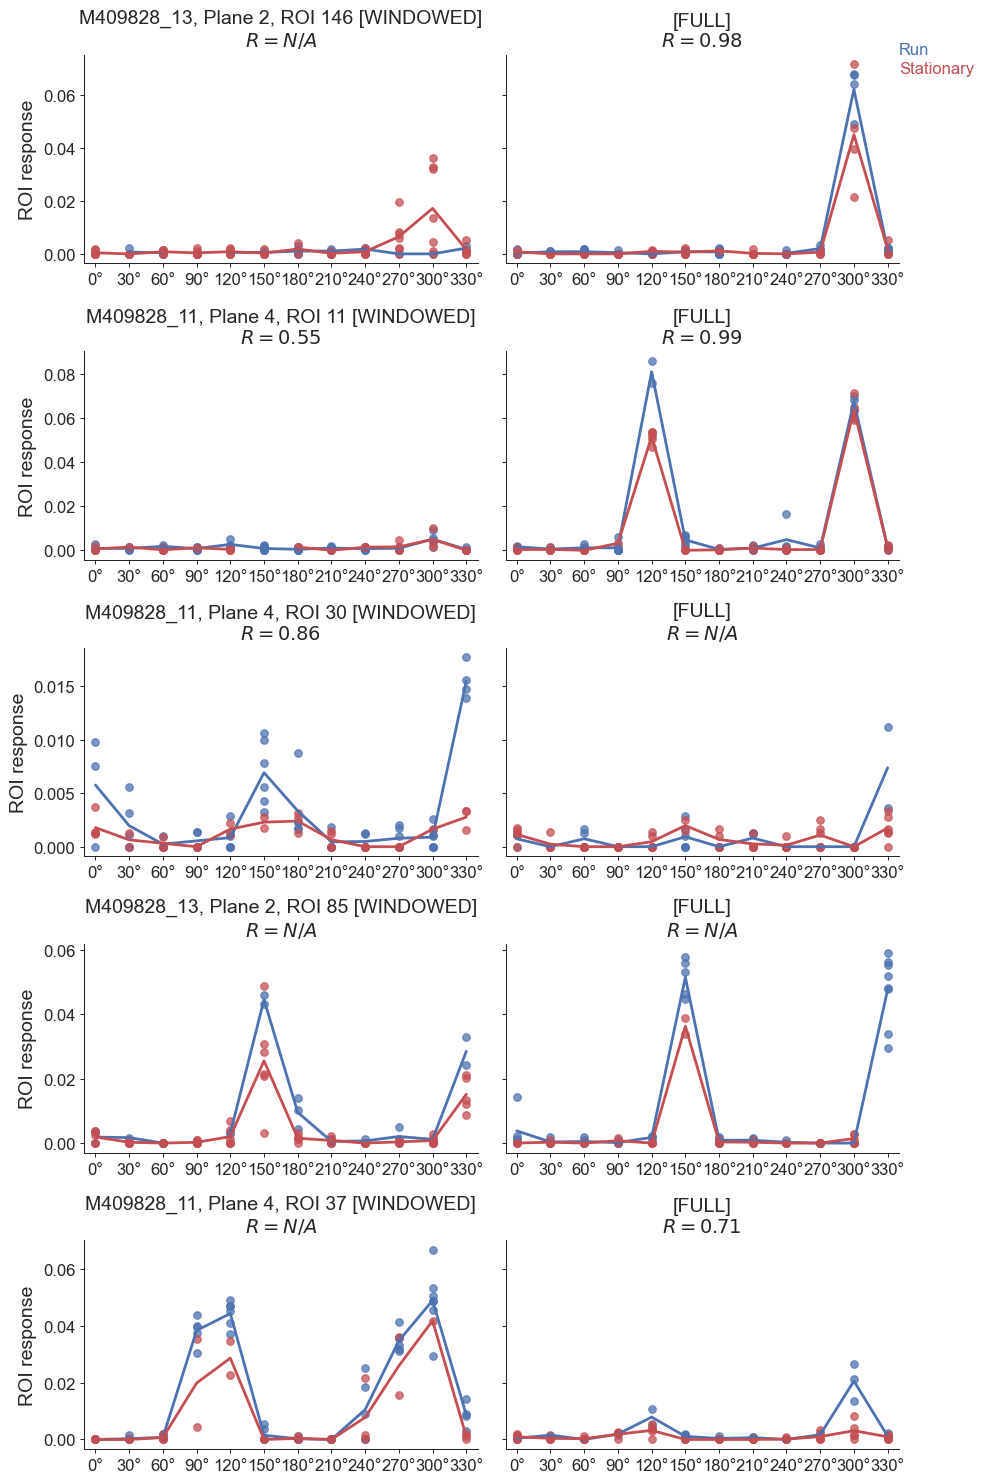

In [111]:
fig, axs = plt.subplots(figsize=(10, 3*len(rois_to_plot)), tight_layout=True, nrows=len(rois_to_plot), ncols=2, sharey="row")

for row, roi_id in enumerate(rois_to_plot):
    plot_dg_responses(*roi_id, dg_type="windowed", consider_running=True, ax=axs[row, 0], show_running_text=False, subtitle=f"$R = {format_r2(df_model_2, 'r', 'windowed', *roi_id)}$")
    plot_dg_responses(*roi_id, dg_type="full", consider_running=True, ax=axs[row, 1], show_running_text=(row==0))
    axs[row, 1].set_ylabel("")
    axs[row, 1].set_title(f"[FULL]\n$R = {format_r2(df_model_2, 'r', 'full', *roi_id)}$")


<Axes: xlabel='r', ylabel='Count'>

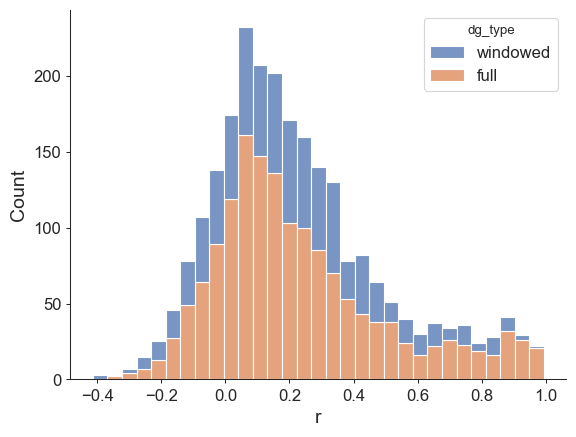

In [123]:
sns.histplot(data=df_model_2, x="r", hue="dg_type", multiple="stack")

Text(0.5, 1.0, 'Mean = 0.226')

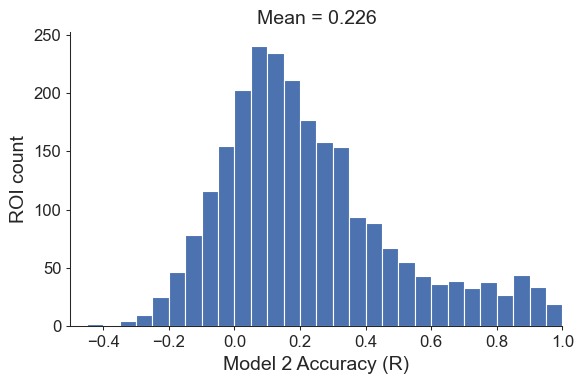

In [126]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.hist(df_model_2.r, bins=np.arange(-1, 1.05, 0.05))
ax.set_xlabel("Model 2 Accuracy (R)")
ax.set_ylabel("ROI count")
ax.set_xlim(-0.5, 1)
ax.set_title(f"Mean = {df_model_2.r.mean():.3f}")

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:24: RuntimeWarning: Mean of empty slice
  tuning_run = np.nanmean(np.where(run_mask, trial_responses[roi], np.nan)[:, pref_sf_idx, :], axis=1) # trial average
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_23046/4109075357.py:25: RuntimeWarning: Mean of empty slice
  tuning_stat = np.nanmean(np.where(stationary_mask, trial_responses[roi], np.nan)[:, pref_sf_idx], axis=1)


mouse  column volume  plane  roi  depth   dg_type         r  \
156   409828       1      1      4   11    114      full  0.993350   
1502  409828       1      3      3   36    290      full  0.984320   
498   409828       1      2      1   16    162      full  0.982210   
1293  409828       1      3      2  101    274      full  0.980398   
1310  409828       1      3      2  146    274      full  0.978630   
...      ...     ...    ...    ...  ...    ...       ...       ...   
1470  409828       1      3      3  381    290  windowed -0.390337   
2358  409828       1      b      0   34    625  windowed -0.406179   
27    409828       1      1      3   30     98  windowed -0.413230   
1148  409828       1      3      1  302    258      full       NaN   
1303  409828       1      3      2  131    274      full       NaN   

      frac_responsive_trials   run_mod  
156                 1.000000 -0.016324  
1502                1.000000  0.028993  
498                 1.000000  0.061407  
1293                1.000000  0.030123  
1310                1.000000  0.050059  
...                      ...       ...  
1470                0.333333  0.014038  
2358                0.285714 -0.040166  
27                  0.500000 -0.032411  
1148                0.250000  0.011499  
1303                0.500000  0.006347  

[2436 rows x 10 columns]

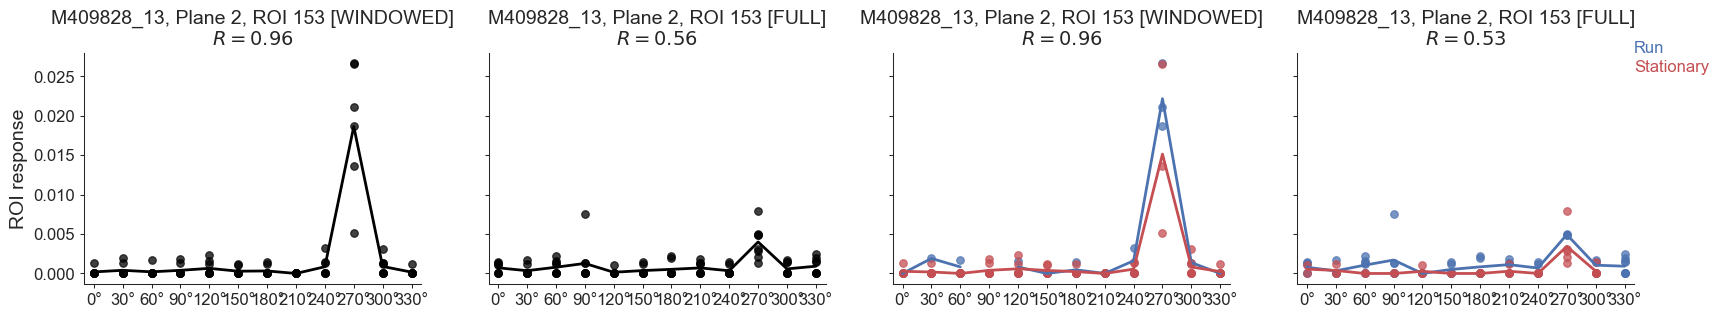

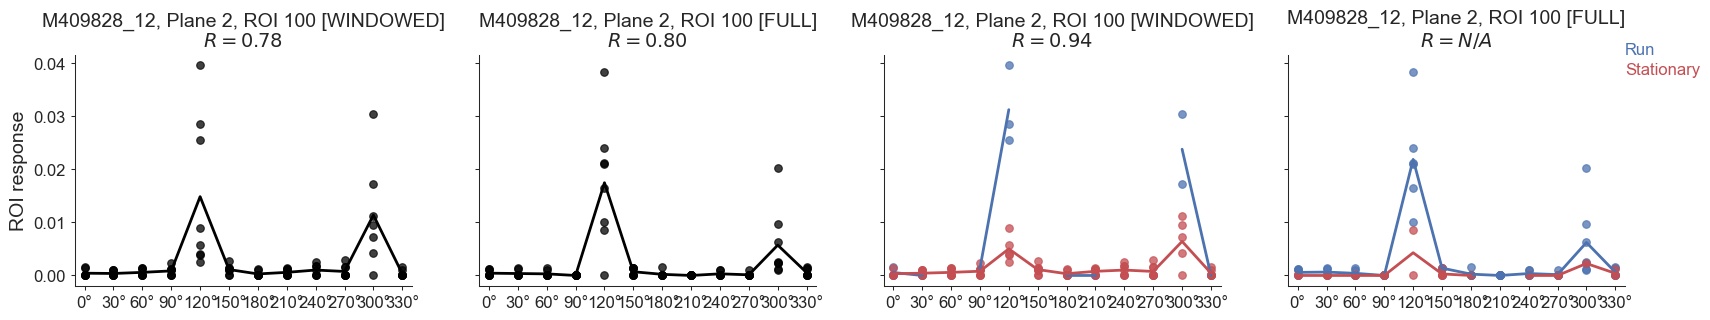

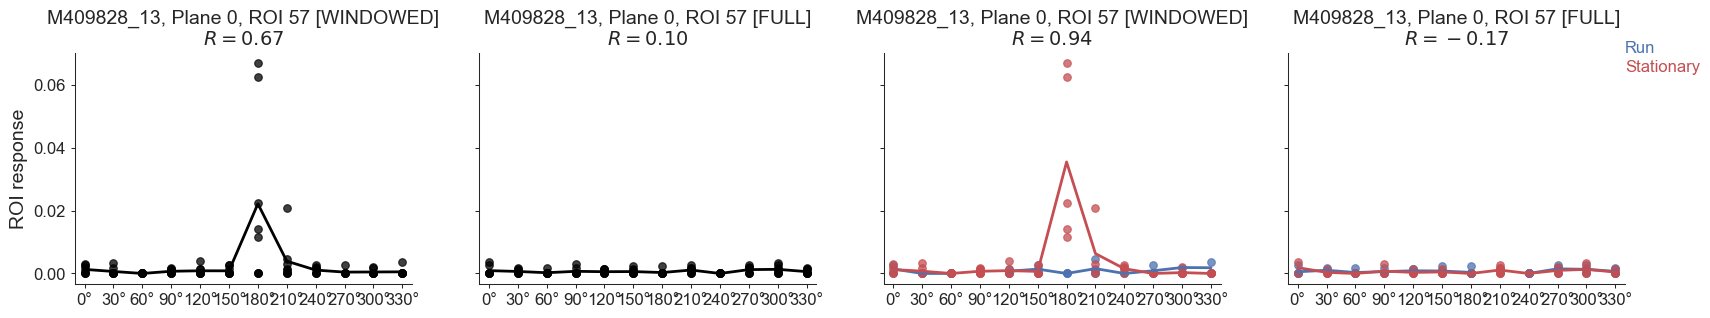

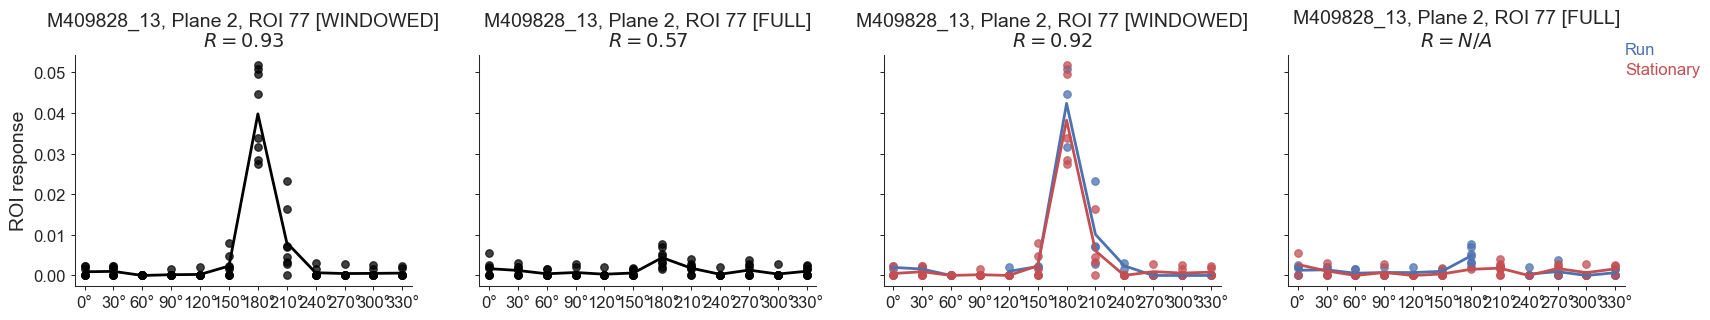

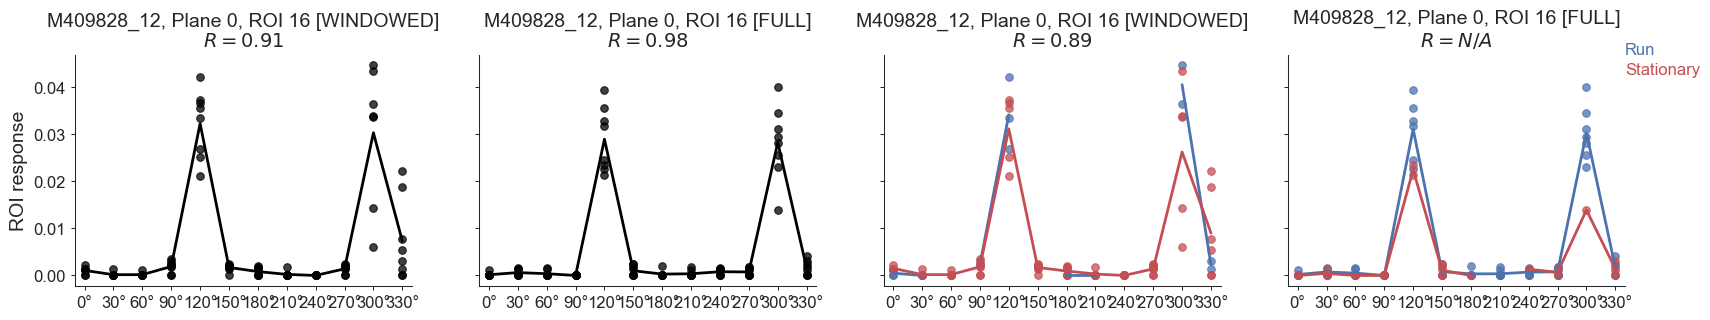

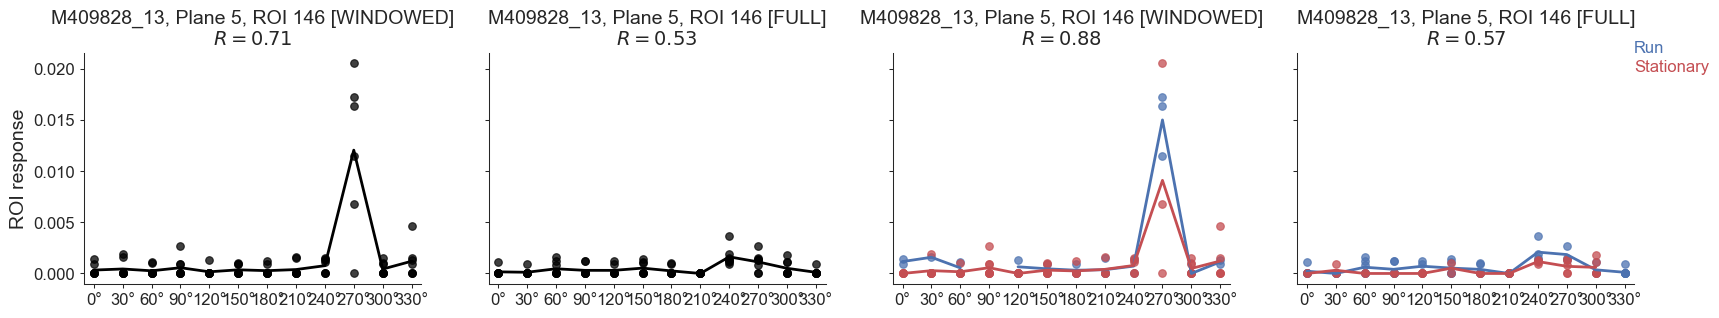

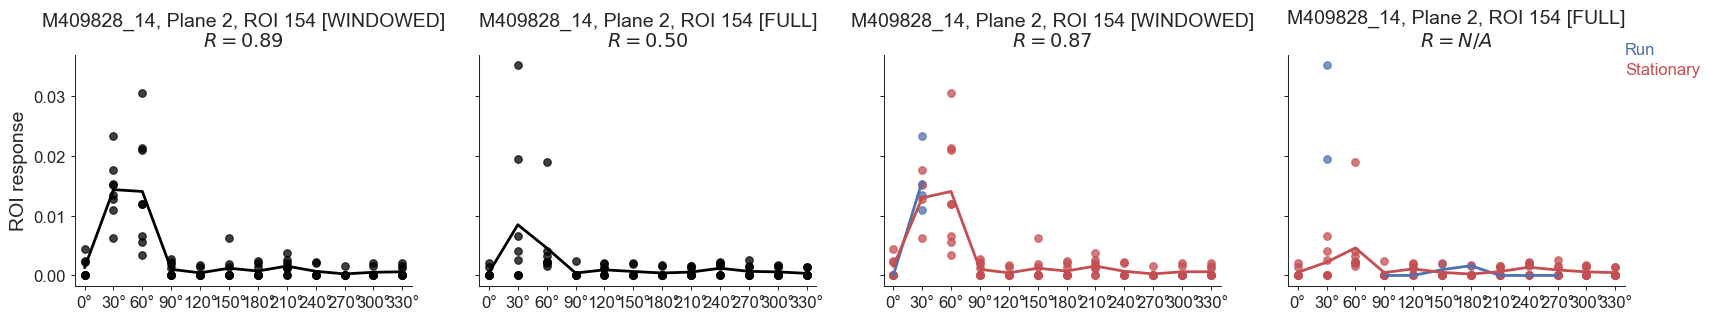

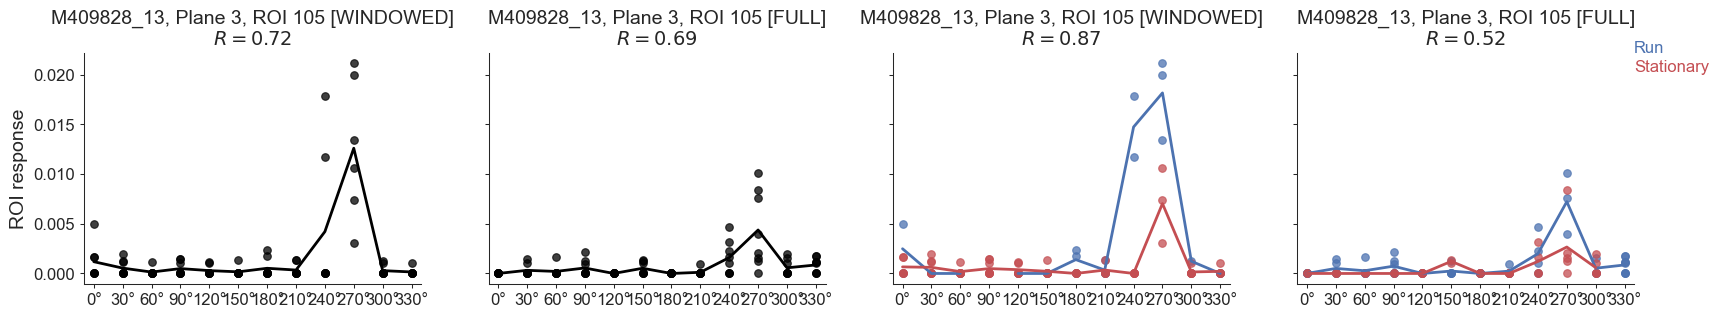

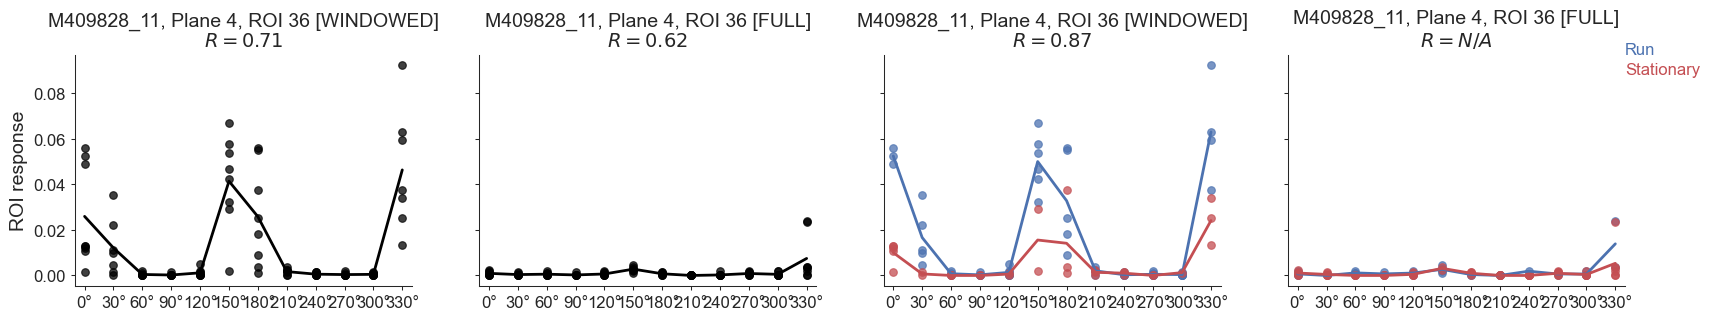

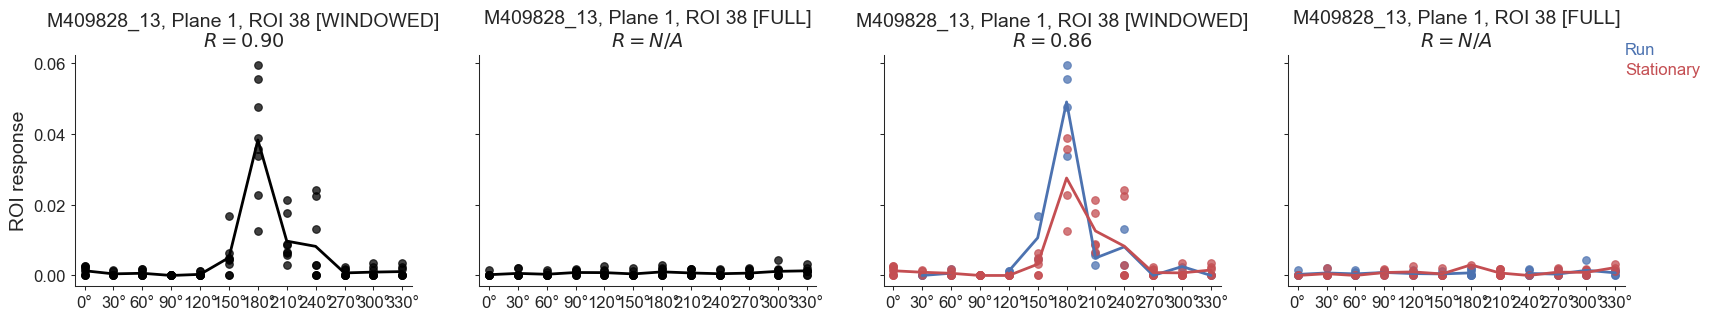

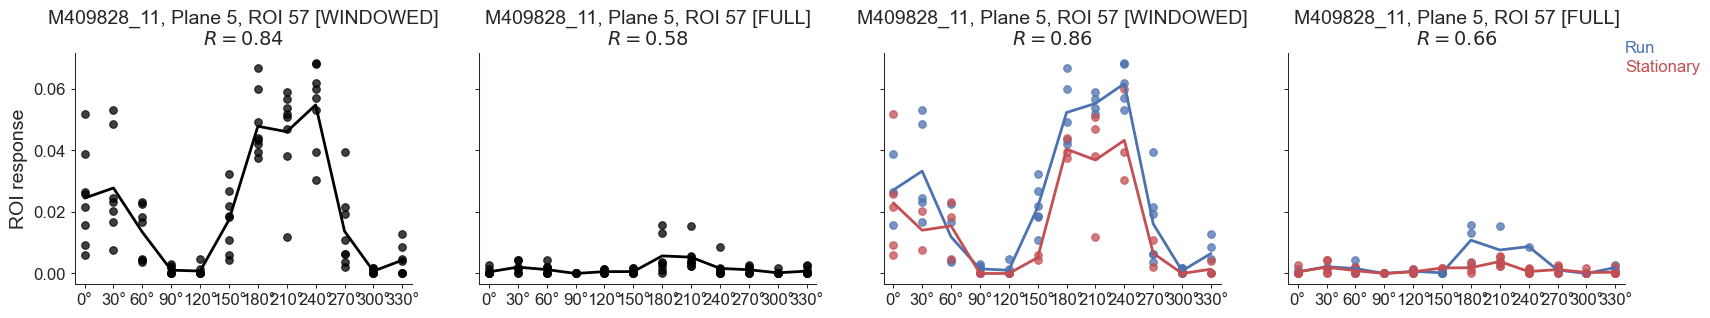

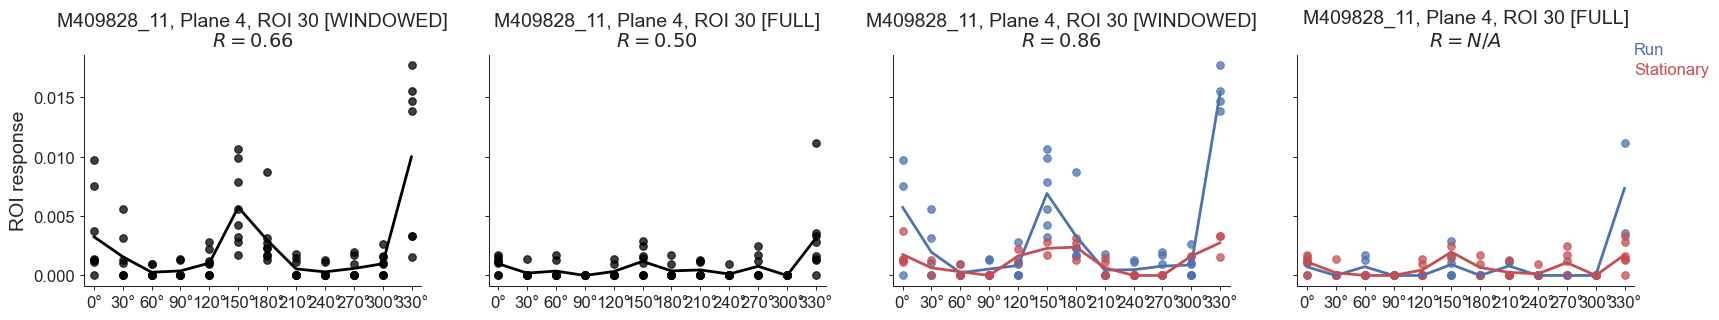

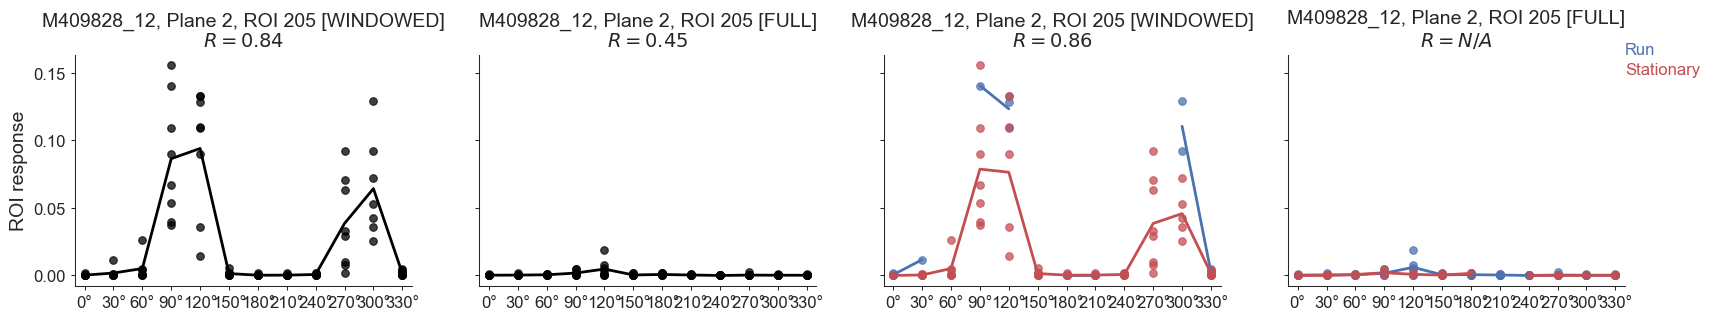

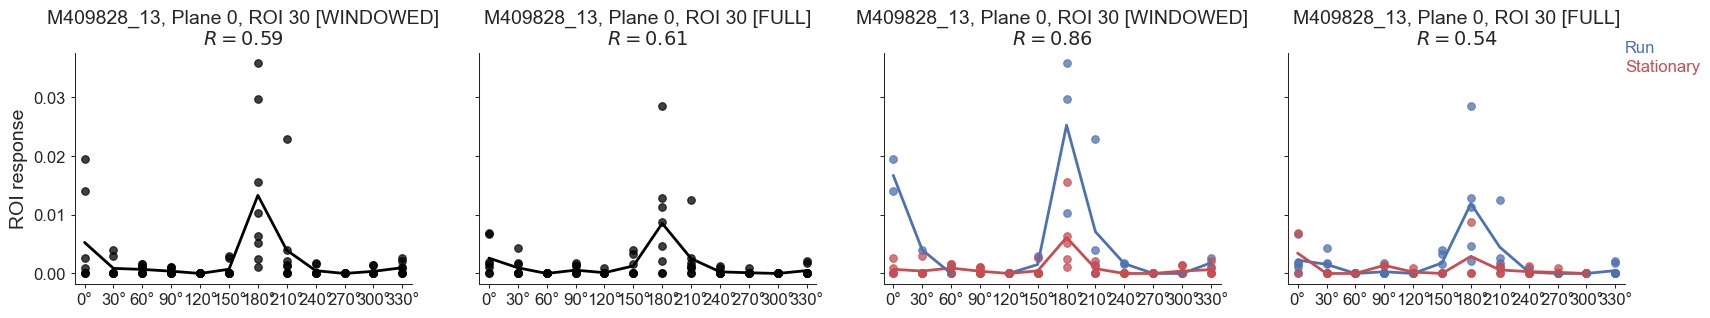

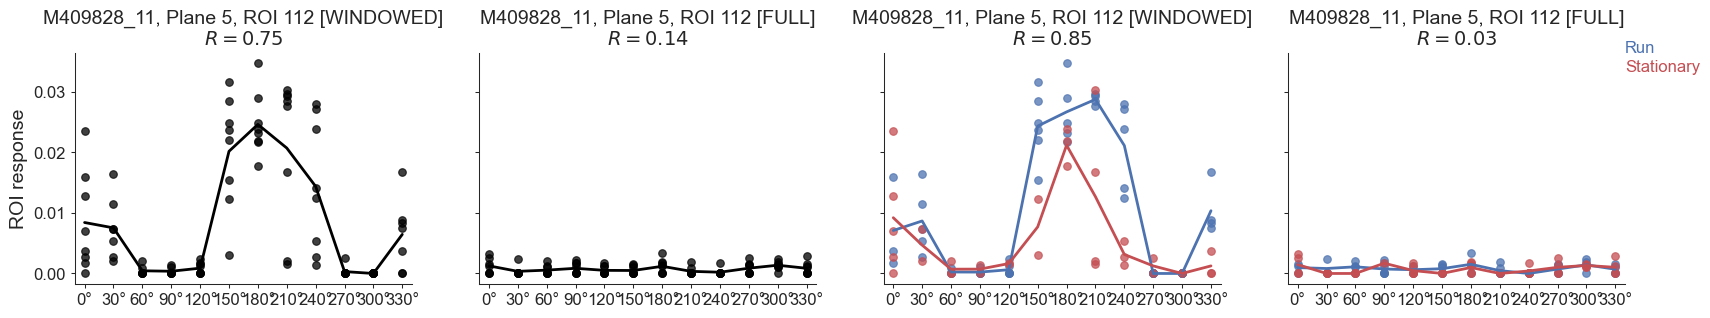

In [121]:
# plot_dg_responses(409828, 1, 3, 0, 51, consider_running=True)

df_sorted = df_model_2.sort_values("r", ascending=False)

for row in df_sorted[df_sorted.dg_type == "windowed"].head(15).itertuples():
# for row in df_sorted.head(15).itertuples():
    i = row[0]
    roi_id = row[1:6]
    dg_type = df_model_2.at[i, "dg_type"]

    fig, axs = plt.subplots(figsize=(20, 3), ncols=4, sharey=True)

    plot_dg_responses(*roi_id, dg_type="windowed", consider_running=False, subtitle=f"$R = {format_r2(df_model_1, 'r', 'windowed', *roi_id)}$", ax=axs[0])
    plot_dg_responses(*roi_id, dg_type="full", consider_running=False, subtitle=f"$R = {format_r2(df_model_1, 'r', 'full', *roi_id)}$", ax=axs[1])
    plot_dg_responses(*roi_id, dg_type="windowed", consider_running=True, subtitle=f"$R = {format_r2(df_model_2, 'r', 'windowed', *roi_id)}$", ax=axs[2], show_running_text=False)
    plot_dg_responses(*roi_id, dg_type="full", consider_running=True, subtitle=f"$R = {format_r2(df_model_2, 'r', 'full', *roi_id)}$", ax=axs[3])
    plt.setp(axs[1:], ylabel="")
    # break

df_sorted

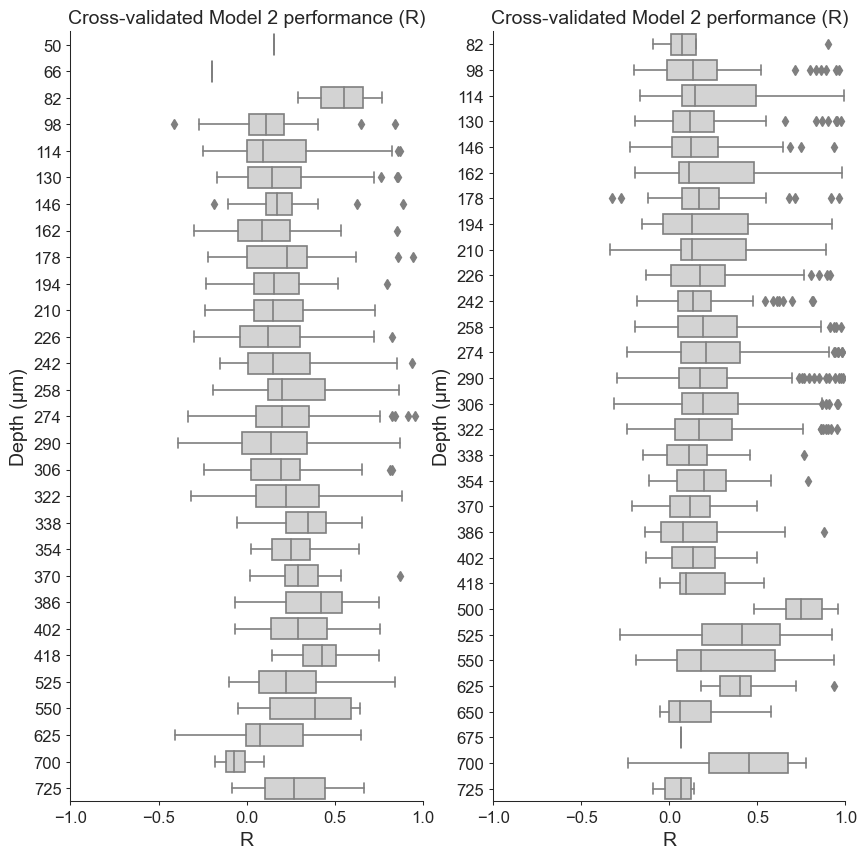

In [122]:
fig, axs = plot_dg_metric_by_depth(df_model_2, "r")

for ax in axs:
    ax.set_title("Cross-validated Model 2 performance (R)")
    ax.set_xlabel("R")
    ax.set_xlim(-1, 1)

(array([  0.,   0.,   0.,   0.,   0.,   6.,  15.,  73., 183., 387., 513.,
        484., 366., 202., 140.,  75.,  60.,  35.,  47.,  15.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <BarContainer object of 20 artists>)

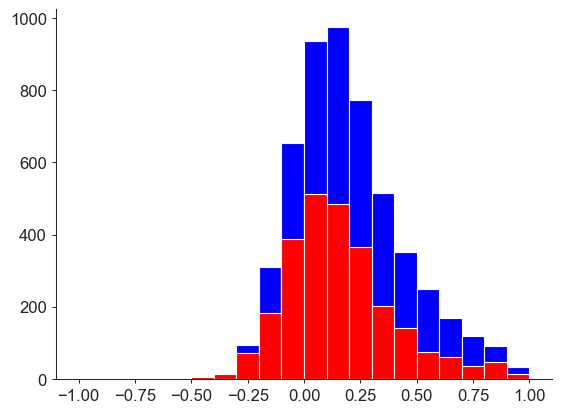

In [629]:
plt.figure()
bins = np.arange(-1, 1.1, 0.1)
plt.hist(df_model_2.r, bins=bins, color="blue")
plt.hist(df.r, bins=bins, color="red")

In [413]:
# Load sample session
for group in iter_plane_groups(filter=dict(mouse=409828, column=1, volume=3)):
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    dgs = group["drifting_gratings_windowed"], group["drifting_gratings_full"]

    dg = dgs[0]

    responsive_rois = np.where(is_responsive)[0]
    trial_responses = dg["trial_responses"][()]
    pref_cond_idx = dg["pref_cond_index"][()]
    n_valid_trials = np.sum(~np.isnan(trial_responses), axis=3)

    for roi in responsive_rois:
        pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]

        trial_index_matrix = []
        class_labels = []

        for dir_i, angle in enumerate(dir_list):
            for trial in range(n_valid_trials[roi, dir_i, pref_sf_idx]):
                label = dir_i

                trial_index_matrix.append([roi, dir_i, pref_sf_idx, trial])
                class_labels.append(label)

        trial_index_matrix = np.array(trial_index_matrix)
        class_labels = np.array(class_labels)

        break
    break

for i, (train_idx, test_idx) in enumerate(skf.split(trial_index_matrix, class_labels)):
    print(f"  Fold {i}:")
    print(trial_index_matrix[train_idx].shape)
    print(trial_responses[trial_index_matrix[train_idx]].shape)

    # print(train_idx)
    # print(test_idx)
    # print(list(trial_index_matrix[train_idx]))
    # print(class_labels[test_idx])
    print()
    break

  Fold 0:
(74, 4)
(74, 4, 12, 2, 8)



In [436]:
i = trial_index_matrix[train_idx]
trial_responses[i[:, 0], i[:, 1], i[:, 2], i[:, 3]].shape

(75,)

In [432]:
list(skf.split(trial_index_matrix, class_labels))

[(array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21,
         23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43,
         44, 45, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 63, 64,
         65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85,
         87, 88, 89, 90, 91, 92]),
  array([ 0,  1,  8, 14, 15, 22, 30, 31, 38, 39, 46, 54, 55, 62, 70, 71, 78,
         79, 86])),
 (array([ 0,  1,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21,
         22, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 41, 42,
         43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 64,
         65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84,
         85, 86, 89, 90, 91, 92]),
  array([ 2,  3,  9, 16, 17, 23, 32, 33, 40, 47, 48, 56, 57, 63, 72, 73, 80,
         87, 88])),
 (array([ 0,  1,  2,  3,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 19, 20,
         21, 22, 23, 26, 27, 28, 29, 30, 31

In [365]:
list(enumerate(trial_responses[roi].direction.values))

[(0, 0),
 (1, 30),
 (2, 60),
 (3, 90),
 (4, 120),
 (5, 150),
 (6, 180),
 (7, 210),
 (8, 240),
 (9, 270),
 (10, 300),
 (11, 330)]

# Model 1: Mean tuning curve model, no running information

In [267]:
rois_to_plot = [(409828, 2, 1, 1, 9), (409828, 4, 2, 1, 19)]

mouse  column  volume  plane  roi  depth dg_type        r2         r  \
0      409828       2       1      0    0     50     dgw  0.177239  0.420997   
1      409828       2       1      0    1     50     dgw  0.149165  0.386219   
2      409828       2       1      0    4     50     dgw  0.307824  0.554819   
3      409828       2       1      0  149     50     dgw  0.129685  0.360119   
4      409828       2       1      0    0     50     dgf  0.179870  0.424111   
...       ...     ...     ...    ...  ...    ...     ...       ...       ...   
33439  409828       5       5      5   52    514     dgf  0.204544  0.452265   
33440  409828       5       5      5   55    514     dgf  0.131894  0.363173   
33441  409828       5       5      5   67    514     dgf  0.157234  0.396527   
33442  409828       5       5      5   73    514     dgf  0.166858  0.408482   
33443  409828       5       5      5   74    514     dgf  0.114132  0.337834   

       frac_responsive_trials   run_mod  
0                    0.666667 -0.016212  
1                    0.500000  0.043872  
2                    0.750000 -0.007672  
3                    0.625000 -0.010710  
4                    0.750000 -0.016212  
...                       ...       ...  
33439                0.375000  0.000963  
33440                0.250000 -0.008496  
33441                0.285714  0.005406  
33442                0.571429 -0.000342  
33443                0.375000  0.007968  

[33444 rows x 11 columns]

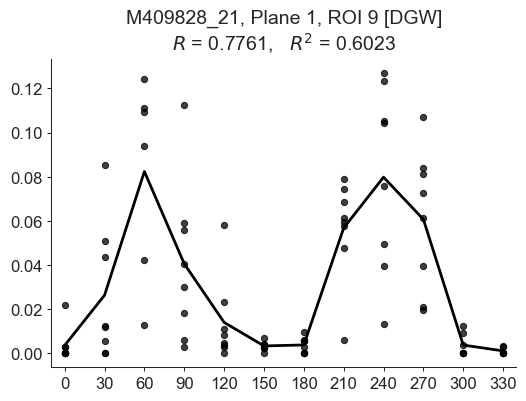

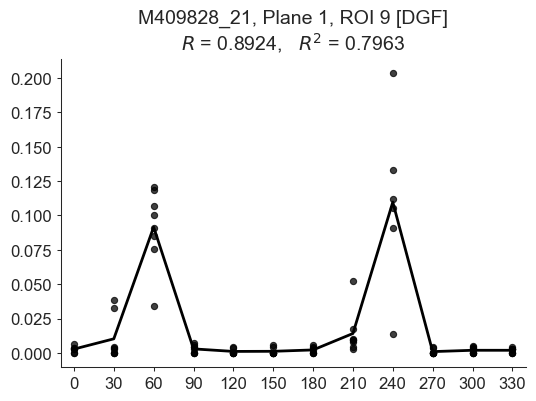

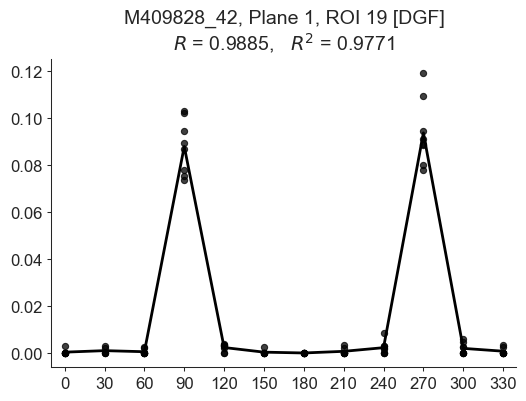

In [316]:
df_model_1 = []

# for group in iter_plane_groups(filter=dict(mouse=409828, column=1, volume=3)):
for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    dgs = group["drifting_gratings_windowed"], group["drifting_gratings_full"]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]
    
    for dg_type, dg in zip(dg_types, dgs):
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        responsive_rois = np.where(is_responsive)[0]
        trial_responses = dg["trial_responses"][()]
        pref_cond_idx = dg["pref_cond_index"][()]

        for roi in responsive_rois:
            pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]
            tuning_curve = [np.nanmean(trial_responses[roi, di, pref_sf_idx]) for di in range(len(dir_list))]

            # Measure R fit score
            y_true, y_pred = [], []
            for di, angle in enumerate(dir_list):
                resp = trial_responses[roi, di, pref_sf_idx]
                for r in resp:
                    if np.isnan(r): continue
                    y_true.append(r)
                    y_pred.append(tuning_curve[di])

            r2 = r2_score(y_true, y_pred)
            r = np.sqrt(r2)

            df_model_1.append(dict(
                mouse = mouse,
                column = column,
                volume = volume,
                plane = plane,
                roi = roi,
                depth = depth,
                dg_type = dg_type,
                r2 = r2,
                r = r,
                frac_responsive_trials = dg["frac_responsive_trials"][roi],
                run_mod = group["running_correlations"][roi]
            ))

            # Plot
            if (mouse, column, volume, plane, roi) in rois_to_plot:
                fig, ax = plt.subplots(figsize=(6, 4))

                for di, angle in enumerate(dir_list):
                    resp = trial_responses[roi, di, pref_sf_idx]
                    resp = resp[~np.isnan(resp)]
                    angle_list = [angle] * len(resp)
                    ax.scatter(angle_list, resp, color="black", s=20, alpha=0.75)

                ax.plot(dir_list, tuning_curve, linewidth=2, color="black")

                ax.set_xticks(dir_list)
                ax.set_xlim(dir_list[0]-10, dir_list[-1]+10)
                ax.set_title(f"M{mouse}_{column}{volume}, Plane {plane}, ROI {roi} [{dg_type.upper()}]\n$R$ = {r:.4f},   $R^2$ = {r2:.4f}")


    # break

df_model_1 = pd.DataFrame(df_model_1)
df_model_1

In [635]:
df_model_1

mouse  column  volume  plane  roi  depth   dg_type        r2  \
0      409828       2       1      0    0     50  windowed -0.139997   
1      409828       2       1      0    1     50  windowed -0.152568   
2      409828       2       1      0    4     50  windowed  0.060155   
3      409828       2       1      0  149     50  windowed -0.148758   
4      409828       2       1      0    0     50      full -0.152220   
...       ...     ...     ...    ...  ...    ...       ...       ...   
33439  409828       5       5      5   52    514      full -0.116167   
33440  409828       5       5      5   55    514      full -0.139557   
33441  409828       5       5      5   67    514      full -0.152829   
33442  409828       5       5      5   73    514      full -0.157050   
33443  409828       5       5      5   74    514      full -0.188783   

              r  frac_responsive_trials   run_mod  
0      0.069411                0.666667 -0.016212  
1      0.044741                0.500000  0.043872  
2      0.342776                0.750000 -0.007672  
3      0.017027                0.625000 -0.010710  
4      0.079878                0.750000 -0.016212  
...         ...                     ...       ...  
33439  0.131462                0.375000  0.000963  
33440  0.032925                0.250000 -0.008496  
33441  0.044415                0.285714  0.005406  
33442  0.052335                0.571429 -0.000342  
33443 -0.047356                0.375000  0.007968  

[33444 rows x 11 columns]

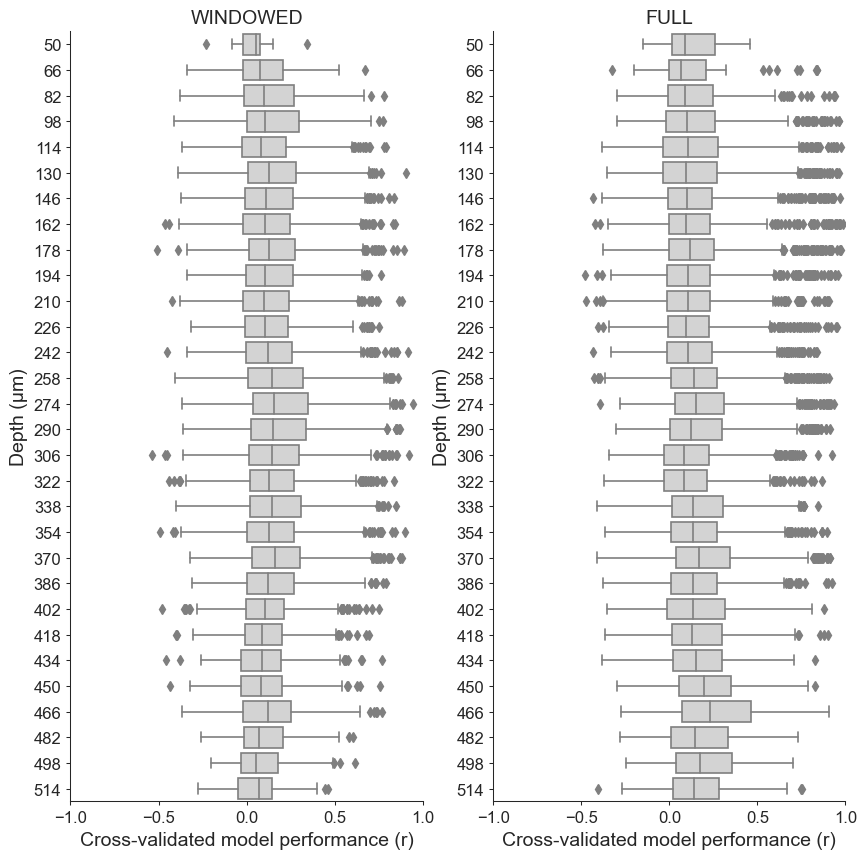

In [649]:
fig, axs = plot_dg_metric_by_depth(df_model_1, "r")

for ax in axs:
    ax.set_xlabel("Cross-validated model performance (r)")
    ax.set_xlim(-1, 1)

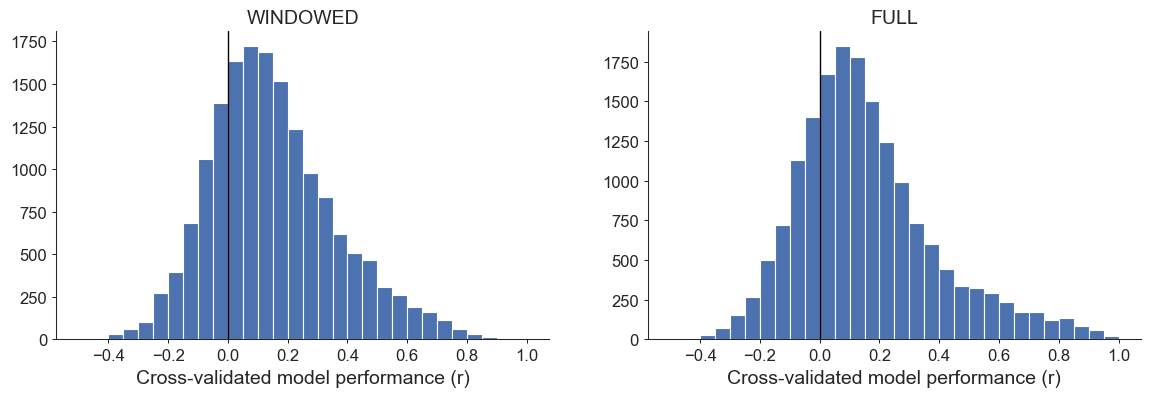

In [648]:
fig, axs = plt.subplots(figsize=(14, 4), ncols=2)

for ax, dg_type in zip(axs, DG_TYPES):
    ax.set_title(dg_type.upper())
    ax.hist(df_model_1["r"][df_model_1.dg_type == dg_type], bins=np.arange(-0.5, 1.05, 0.05))
    ax.axvline(x=0, color="black", linewidth=1)
    ax.set_xlabel("Cross-validated model performance (r)")

# Model 2. Mean tuning curve model, with running information
Only for sessions where ≥k stationary and ≥k running trials, k = 3

Text(0.5, 0, 'Frac of trials where mouse is stationary')

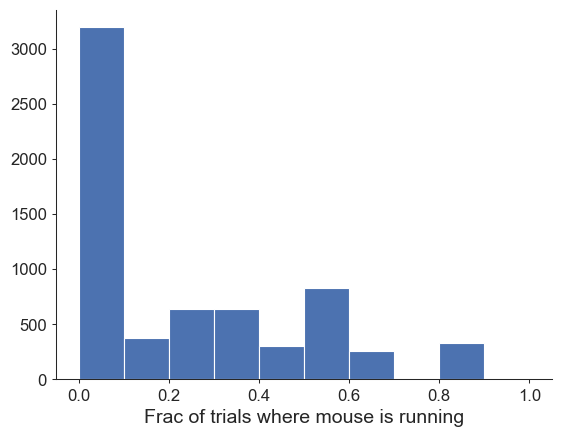

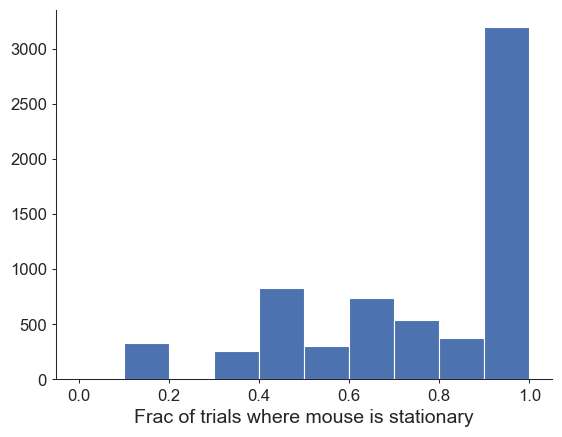

In [271]:
frac_running_trials = []
frac_stationary_trials = []

# for group in iter_plane_groups(filter=dict(mouse=409828, column=1)):
for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    dgs = group["drifting_gratings_windowed"], group["drifting_gratings_full"]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    dg = dgs[0] # DGW
    is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.5)
    responsive_rois = np.where(is_responsive)[0]
    trial_responses = dg["trial_responses"][()]
    pref_cond_idx = dg["pref_cond_index"][()]
    abs_trial_running_speeds = np.abs(dg["trial_running_speeds"][()])
    is_stationary = abs_trial_running_speeds < 1
    is_running = abs_trial_running_speeds >= 1 # note this is not ~is_stationary so nan trials (no stimulus shown) are False

    for roi in responsive_rois:
        pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]
        total_trials = np.sum(~np.isnan(trial_responses[roi, :, pref_sf_idx]))
        frac_running_trials.append(np.sum(is_running[:, pref_sf_idx]) / total_trials)
        frac_stationary_trials.append(np.sum(is_stationary[:, pref_sf_idx]) / total_trials)

bins = np.arange(0, 1.1, 0.1)
plt.hist(frac_running_trials, bins=bins)
plt.xlabel("Frac of trials where mouse is running")

plt.figure()
plt.hist(frac_stationary_trials, bins=bins)
plt.xlabel("Frac of trials where mouse is stationary")

mouse  column  volume  plane  roi  depth dg_type        r2         r  \
0      409828       2       1      0    0     50     dgw  0.436514  0.660692   
1      409828       2       1      0    1     50     dgw  0.215678  0.464412   
2      409828       2       1      0    4     50     dgw  0.482544  0.694654   
3      409828       2       1      0  149     50     dgw  0.406580  0.637636   
4      409828       2       1      1    0     66     dgw  0.336005  0.579659   
...       ...     ...     ...    ...  ...    ...     ...       ...       ...   
10657  409828       5       4      5  312    418     dgf  0.209999  0.458256   
10658  409828       5       4      5  345    418     dgf  0.293648  0.541893   
10659  409828       5       4      5  399    418     dgf  0.344701  0.587112   
10660  409828       5       4      5  401    418     dgf  0.248009  0.498005   
10661  409828       5       4      5  416    418     dgf  0.211333  0.459710   

       frac_responsive_trials   run_mod  
0                    0.666667 -0.016212  
1                    0.500000  0.043872  
2                    0.750000 -0.007672  
3                    0.625000 -0.010710  
4                    0.250000  0.019992  
...                       ...       ...  
10657                0.250000  0.034162  
10658                0.250000  0.013875  
10659                0.375000  0.009186  
10660                0.375000  0.011270  
10661                0.250000  0.019773  

[10662 rows x 11 columns]

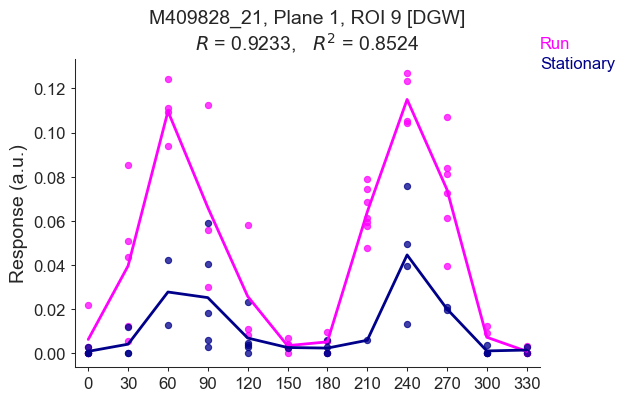

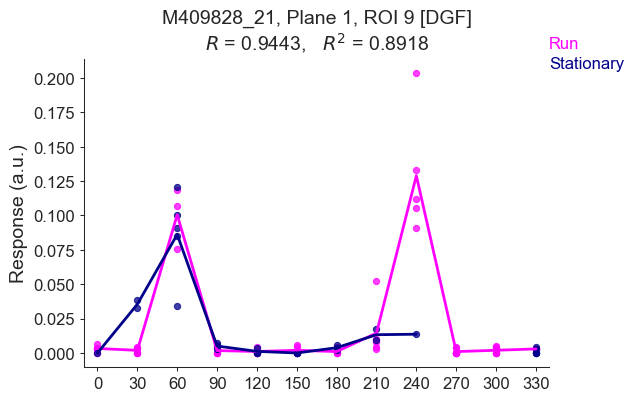

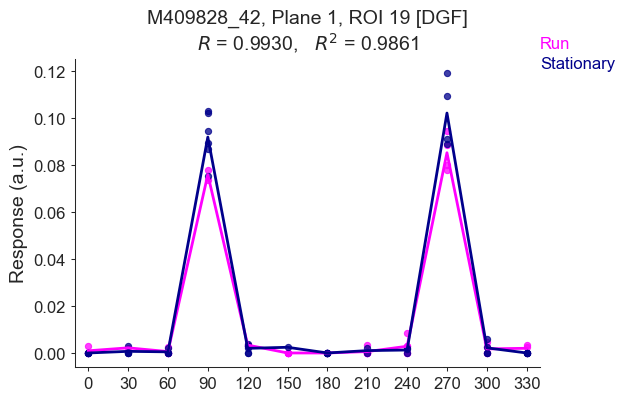

In [528]:
dir_list = np.arange(0, 360, 30, dtype=int)
df_model_2 = []
k = 1

COLOR_RUN = "magenta"
COLOR_STATIONARY = "darkblue"

# for group in iter_plane_groups(filter=dict(mouse=409828, column=1)):
for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    dgs = group["drifting_gratings_windowed"], group["drifting_gratings_full"]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]
    
    for dg_type, dg in zip(dg_types, dgs):
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        responsive_rois = np.where(is_responsive)[0]
        trial_responses = dg["trial_responses"][()]
        pref_cond_idx = dg["pref_cond_index"][()]
        abs_trial_running_speeds = np.abs(dg["trial_running_speeds"][()])
        is_stationary = abs_trial_running_speeds < 1
        is_running = abs_trial_running_speeds >= 1 # note this is not ~is_stationary so nan trials (no stimulus shown) are False

        for roi in responsive_rois:
            pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]
            tuning_curve_run = np.full_like(dir_list, np.nan, dtype=float)
            tuning_curve_stat = np.full_like(dir_list, np.nan, dtype=float)
            tuning_curve_run_count = np.zeros_like(dir_list, dtype=int)
            tuning_curve_stat_count = np.zeros_like(dir_list, dtype=int)

            for di, angle in enumerate(dir_list):
                for mask, tune, tune_counts in ((is_running, tuning_curve_run, tuning_curve_run_count), (is_stationary, tuning_curve_stat, tuning_curve_stat_count)):
                    resp = trial_responses[roi, di, pref_sf_idx, mask[di, pref_sf_idx]]
                    tune_counts[di] = len(resp)
                    if len(resp) > 0:
                        tune[di] = np.mean(resp)

            # should_include = tuning_curve_run_count.min() >= k and tuning_curve_stat_count.min() >= k # Strict
            should_include = (tuning_curve_run_count == 0).sum() <= 1 and (tuning_curve_stat_count == 0).sum() <= 1 # More lax

            # Measure R fit score
            y_true, y_pred = [], []
            for di, angle in enumerate(dir_list):
                resp = trial_responses[roi, di, pref_sf_idx]
                for ri, r in enumerate(resp):
                    if np.isnan(r): break
                    y_true.append(r)
                    y_pred.append(tuning_curve_run[di] if is_running[di, pref_sf_idx, ri] else tuning_curve_stat[di])

            r2 = r2_score(y_true, y_pred)
            r = np.sqrt(r2)

            if should_include:
                df_model_2.append(dict(
                    mouse = mouse,
                    column = column,
                    volume = volume,
                    plane = plane,
                    roi = roi,
                    depth = depth,
                    dg_type = dg_type,
                    r2 = r2,
                    r = r,
                    frac_responsive_trials = dg["frac_responsive_trials"][roi],
                run_mod = group["running_correlations"][roi]
                ))

            # Plot
            if (mouse, column, volume, plane, roi) in rois_to_plot or (mouse == 409828 and column == 1 and volume == 3 and plane == 0 and roi == 51):
                fig, ax = plt.subplots(figsize=(6, 4))

                for di, angle in enumerate(dir_list):
                    resp_run = trial_responses[roi, di, pref_sf_idx, is_running[di, pref_sf_idx]]
                    resp_stat = trial_responses[roi, di, pref_sf_idx, is_stationary[di, pref_sf_idx]]

                    ax.scatter([angle] * len(resp_run), resp_run, color=COLOR_RUN, s=20, alpha=0.75)
                    ax.scatter([angle] * len(resp_stat), resp_stat, color=COLOR_STATIONARY, s=20, alpha=0.75)

                ax.plot(dir_list, tuning_curve_run, color=COLOR_RUN, linewidth=2)
                ax.plot(dir_list, tuning_curve_stat, color=COLOR_STATIONARY, linewidth=2)

                ax.set_xticks(dir_list)
                ax.set_xlim(dir_list[0]-10, dir_list[-1]+10)
                ax.set_title(f"M{mouse}_{column}{volume}, Plane {plane}, ROI {roi} [{dg_type.upper()}]\n$R$ = {r:.4f},   $R^2$ = {r2:.4f}")
                ax.set_ylabel("Response (a.u.)")
                ax.text(1, 1.05, "Run", color=COLOR_RUN, va="center", ha="left", transform=ax.transAxes)
                ax.text(1, 0.985, "Stationary", color=COLOR_STATIONARY, va="center", ha="left", transform=ax.transAxes)


    # break

df_model_2 = pd.DataFrame(df_model_2)
df_model_2

In [650]:
df_model_2.sort_values("r2", ascending=False)

mouse  column  volume  plane  roi  depth   dg_type        r2         r  \
2068  409828       4       2      1   19    162      full  0.976135  0.988000   
4878  409828       5       4      0  119    338  windowed  0.925569  0.962275   
1399  409828       3       1      2    0     82      full  0.925500  0.962219   
2203  409828       4       2      3   59    194      full  0.917355  0.957954   
634   409828       2       4      2   42    370  windowed  0.916813  0.957671   
...      ...     ...     ...    ...  ...    ...       ...       ...       ...   
1006  409828       2       5      0   10    434  windowed -0.745403  0.038884   
4461  409828       4       4      4  299    402  windowed -0.778106 -0.188597   
4327  409828       4       4      3  136    386  windowed -0.791104 -0.048297   
461   409828       2       4      0  435    338  windowed -0.829262 -0.236150   
905   409828       2       4      4  172    402  windowed -0.881719 -0.159822   

      frac_responsive_trials   run_mod  
2068                1.000000  0.105032  
4878                0.625000  0.058136  
1399                1.000000  0.140689  
2203                1.000000  0.067251  
634                 0.750000  0.121650  
...                      ...       ...  
1006                0.250000  0.104249  
4461                0.285714  0.005097  
4327                0.428571  0.107873  
461                 0.250000 -0.006436  
905                 0.500000 -0.000614  

[5281 rows x 11 columns]

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_53210/4212023629.py:24: RuntimeWarning: Mean of empty slice
  tuning_stat = np.nanmean(np.where(stationary_mask, trial_responses[roi], np.nan)[:, pref_sf_idx], axis=1)


<Axes: title={'center': 'M409828_24, Plane 2, ROI 42 [FULL]'}, ylabel='ROI response'>

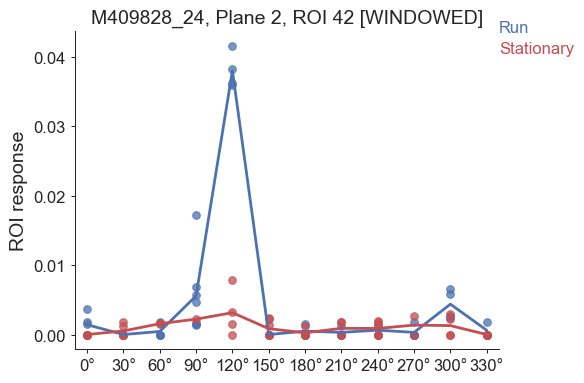

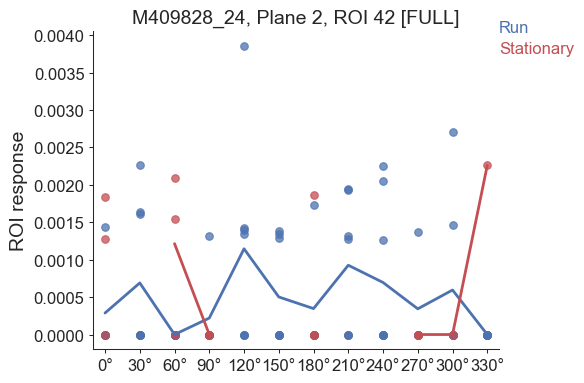

In [658]:
# plot_dg_responses(409828, 4, 2, 1, 19, dg_type="windowed", consider_running=True)
# plot_dg_responses(409828, 4, 2, 1, 19, dg_type="full", consider_running=True)
plot_dg_responses(409828, 2, 4, 2, 42, dg_type="windowed", consider_running=True)
plot_dg_responses(409828, 2, 4, 2, 42, dg_type="full", consider_running=True)
# plot_dg_responses(409828, 4, 2, 1, 19, dg_type="full", consider_running=True)

In [97]:
for dg_type in DG_TYPES:
    r_mean = df_model_2[df_model_2.dg_type == dg_type].r.mean()
    print(f"{dg_type.upper()} Mean r = {r_mean:.4f}")

WINDOWED Mean r = 0.2265
FULL Mean r = 0.2406


<Axes: xlabel='r', ylabel='depth'>

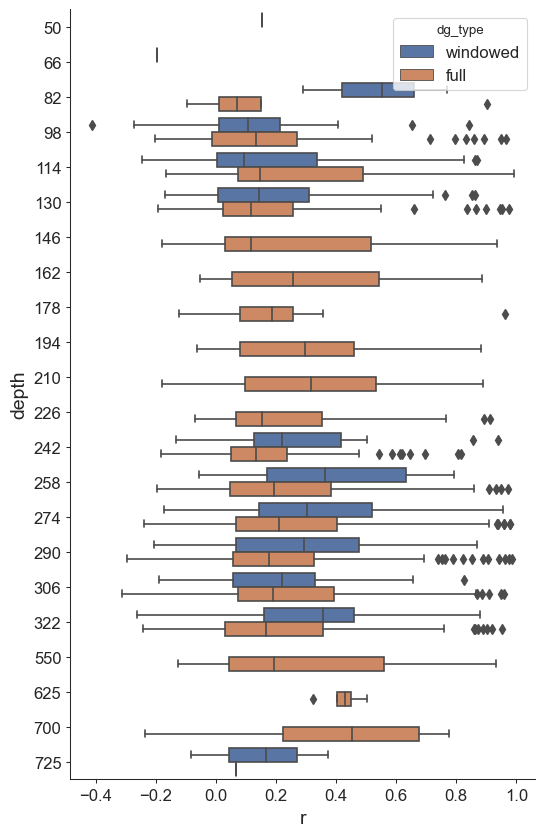

In [98]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.boxplot(df_model_2, x="r", y="depth", orient="horizontal", hue="dg_type", ax=ax)

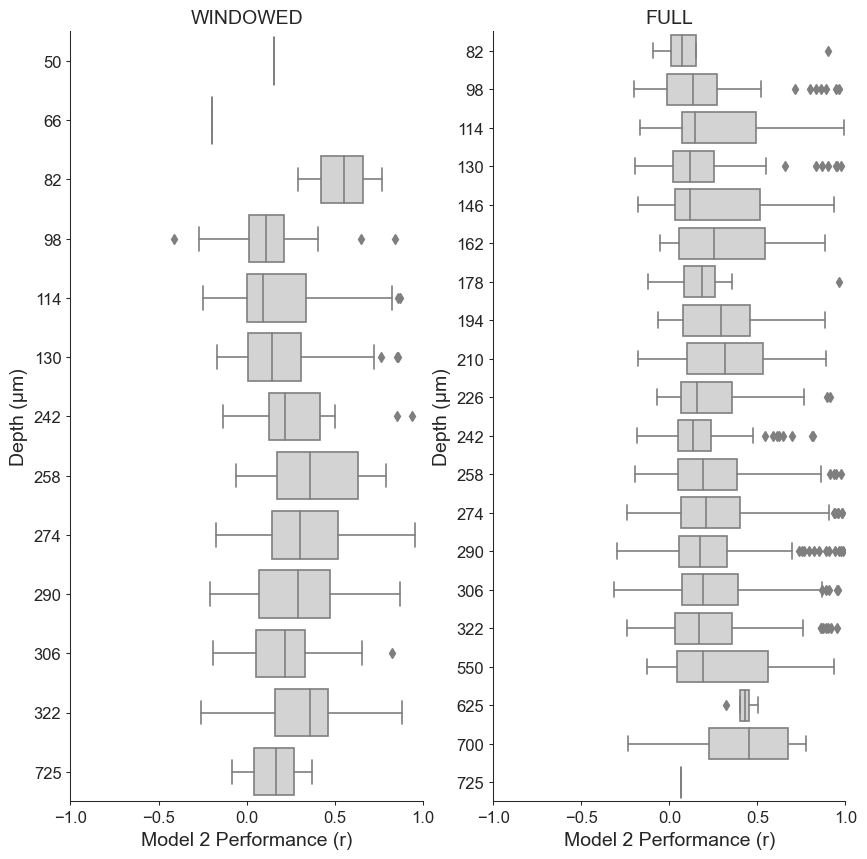

In [100]:
fig, axs = plot_dg_metric_by_depth(df_model_2[df_model_2.frac_responsive_trials >= 0.25], metric="r")
for ax in axs:
    ax.set_xlabel("Model 2 Performance (r)")
    ax.set_xlim(-1, 1)

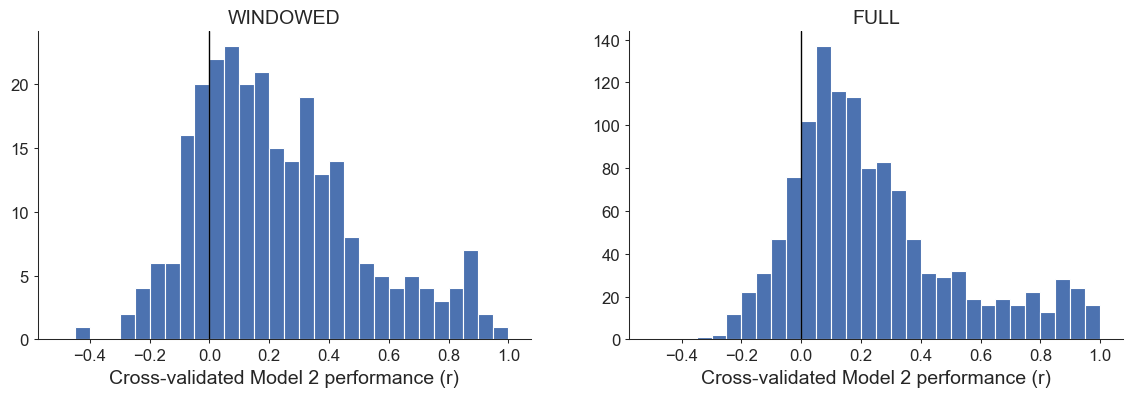

In [101]:
fig, axs = plt.subplots(figsize=(14, 4), ncols=2)

for ax, dg_type in zip(axs, DG_TYPES):
    ax.set_title(dg_type.upper())
    ax.hist(df_model_2["r"][df_model_2.dg_type == dg_type], bins=np.arange(-0.5, 1.05, 0.05))
    ax.axvline(x=0, color="black", linewidth=1)
    ax.set_xlabel("Cross-validated Model 2 performance (r)")

# Measure performance difference across models

In [104]:
df_models_12_merged = pd.merge(left=df_model_1, right=df_model_2, on=["mouse", "column", "volume", "plane", "roi", "dg_type"], how="inner", suffixes=("_model_1", "_model_2"))
df_models_12_merged

mouse  column volume  plane  roi  depth_model_1   dg_type  r_model_1  \
0     409828       1      1      0   89             50  windowed   0.165937   
1     409828       1      1      1    4             66  windowed   0.145856   
2     409828       1      1      2   15             82  windowed   0.414420   
3     409828       1      1      2   17             82  windowed   0.626051   
4     409828       1      1      2  766             82  windowed   0.087447   
...      ...     ...    ...    ...  ...            ...       ...        ...   
1466  409828       1      e      0  180            700      full   0.477168   
1467  409828       1      f      0    4            725  windowed   0.118537   
1468  409828       1      f      0   13            725  windowed   0.071519   
1469  409828       1      f      0   24            725  windowed   0.160644   
1470  409828       1      f      0    2            725      full   0.218616   

      frac_responsive_trials_model_1  run_mod_model_1  depth_model_2  \
0                           0.375000         0.011718             50   
1                           0.428571         0.007350             66   
2                           0.571429         0.040576             82   
3                           1.000000         0.125417             82   
4                           0.250000         0.009319             82   
...                              ...              ...            ...   
1466                        0.857143         0.037828            700   
1467                        0.250000        -0.001472            725   
1468                        0.250000         0.001250            725   
1469                        0.428571         0.030561            725   
1470                        0.250000        -0.007846            725   

      r_model_2  frac_responsive_trials_model_2  run_mod_model_2  
0      0.153334                        0.375000         0.011718  
1     -0.194643                        0.428571         0.007350  
2      0.551443                        0.571429         0.040576  
3      0.768863                        1.000000         0.125417  
4      0.289715                        0.250000         0.009319  
...         ...                             ...              ...  
1466   0.357965                        0.857143         0.037828  
1467  -0.081155                        0.250000        -0.001472  
1468   0.167969                        0.250000         0.001250  
1469   0.372063                        0.428571         0.030561  
1470   0.066941                        0.250000        -0.007846  

[1471 rows x 14 columns]

In [697]:
df_run_mod.run_mod.mean() + 2*df_run_mod.run_mod.std()

0.08180734956674145

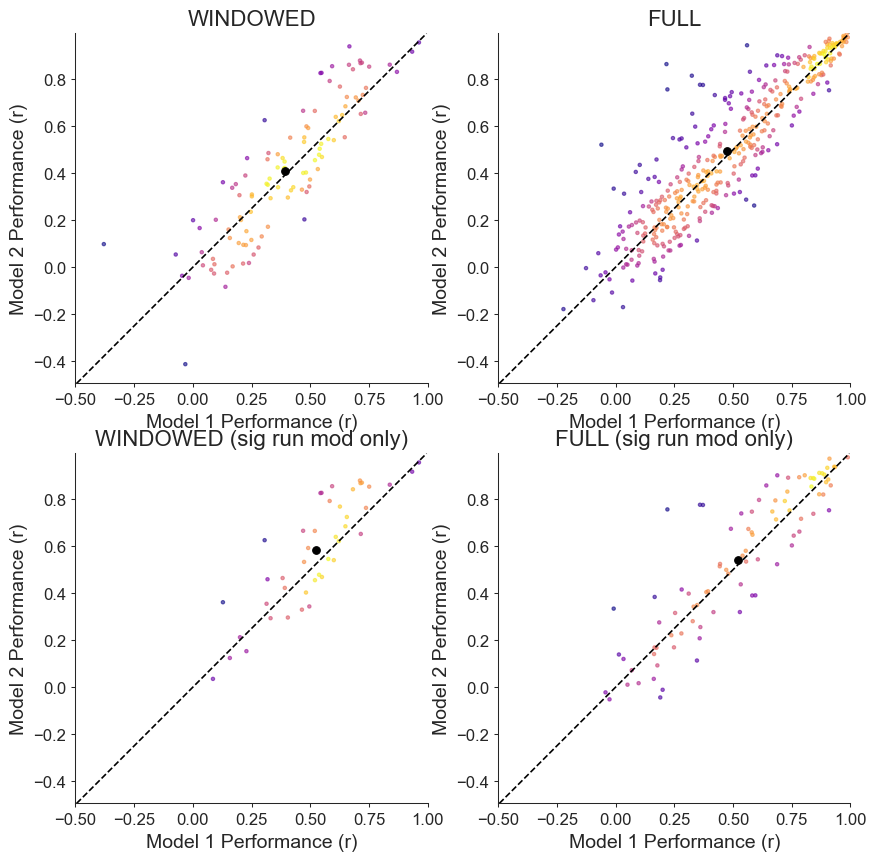

In [106]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

for (ax, ax_sig), dg_type in zip(axs.T, DG_TYPES):
    df = df_models_12_merged[df_models_12_merged.dg_type == dg_type]
    df = df[df.frac_responsive_trials_model_1 >= 0.5] # model 1 and 2 have same frac resp.

    at.density_scatter(
        x = df.r_model_1,
        y = df.r_model_2,
        s=6,
        ax = ax,
        xlabel = "Model 1 Performance (r)",
        ylabel = "Model 2 Performance (r)",
        title = dg_type.upper(),
    )
    ax.scatter(df.r_model_1.mean(), df.r_model_2.mean(), color="black", s=30)
    ax.axis("equal")
    lims = (-0.5, 1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.axline((0, 0), slope=1, color="black", linestyle="dashed")


    df = df[df.run_mod_model_1.abs() >= 0.05]
    at.density_scatter(
        x = df.r_model_1,
        y = df.r_model_2,
        s=6,
        ax = ax_sig,
        xlabel = "Model 1 Performance (r)",
        ylabel = "Model 2 Performance (r)",
        title = f"{dg_type.upper()} (sig run mod only)"
    )
    ax_sig.scatter(df.r_model_1.mean(), df.r_model_2.mean(), color="black", s=30)
    ax_sig.axis("equal")
    ax_sig.set_xlim(lims)
    ax_sig.set_ylim(lims)
    ax_sig.axline((0, 0), slope=1, color="black", linestyle="dashed")

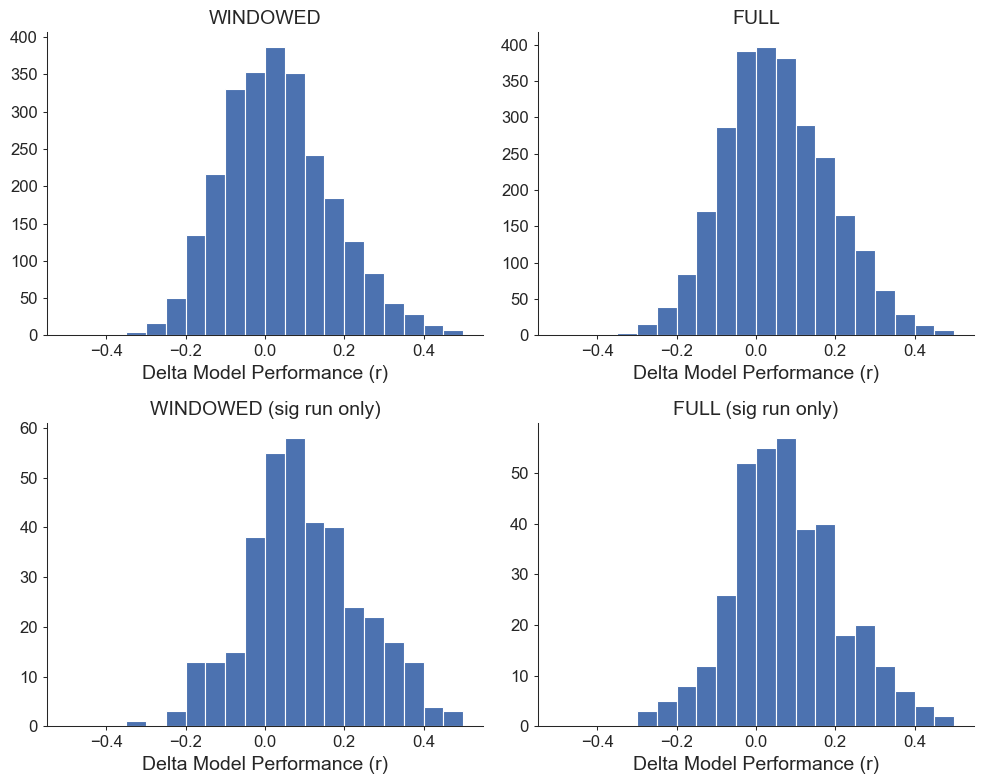

In [701]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, tight_layout=True)
bins = np.arange(-0.5, 0.55, 0.05)

for (ax, ax_sig), dg_type in zip(axs.T, DG_TYPES):
    df = df_models_12_merged[df_models_12_merged.dg_type == dg_type]
    delta_r = df.r_model_2 - df.r_model_1

    ax.hist(delta_r, bins=bins)
    ax.set_title(dg_type.upper())
    ax.set_xlabel("Delta Model Performance (r)")

    ax_sig.hist(delta_r[df.run_mod_model_1 >= 0.05], bins=bins)
    ax_sig.set_title(f"{dg_type.upper()} (sig run only)")
    ax_sig.set_xlabel("Delta Model Performance (r)")

    


    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 1)
    # ax.plot([0, 1], [0, 1], transform=ax.transAxes)